# 0.0 IMPORTS

In [1]:
from IPython.display       import Image
from IPython.core.display  import HTML

import pandas  as pd
import numpy   as np
import seaborn as sns
import random
import math
import openpyxl
import inflection
import datetime
import pickle
from matplotlib            import pyplot as plt
from scipy                 import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model  import LinearRegression, Lasso
from boruta                import BorutaPy
from matplotlib.gridspec   import GridSpec
import xgboost as xgb

import warnings


C:\Users\SBG\anaconda3\envs\Rossmann\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1. Helper Functions

In [37]:
def jupyter_settings():
    
    %matplotlib inline
    
    plt.style.use ('bmh')
    plt.rcParams ['figure.figsize'] = [22,12]
    plt.rcParams ['font.size'] = 12
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
       
    warnings.filterwarnings("ignore")

    
    
def cramer_v (x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]

    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - ((k-1)**2)/(n-1)
    rcorr = r - ((r-1)**2)/(n-1)

    return np.sqrt ((chi2corr/n) / (min( kcorr-1, rcorr-1)))


def ml_error (model_name,y,yhat):

    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error (y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame ({'Model Name':model_name,'MAE':mae,'MAPE':mape,'RMSE':rmse}, index = [0])

def cross_validation (x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []


    for k in reversed(range(1,kfold+1)):
        if verbose:
            print(f'Kfold Number{k}\n')

        # start and end date for validation
        validation_start_date = x_training['date'].max()-datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max()-datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date']>=validation_start_date) & (x_training['date']<=validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model

        m = model.fit(xtraining,ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error (model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name' : model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round (np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round (np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round (np.std(rmse_list),2).astype(str)}, index = [0])
                                                                            
                                                                                                                                          

In [38]:
jupyter_settings()

## 0.2. Loading data


In [4]:
df_sales_raw = pd.read_csv('datasets/train.csv',low_memory=False)

df_store_raw = pd.read_csv('datasets/store.csv',low_memory=False)

# merge datasets

df_raw = pd.merge (df_sales_raw, df_store_raw, on='Store', how='left')

df_raw.head(10)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


# 1.0. Step 01 - DATA DESCRIPTIONS

In [5]:
df1 = df_raw.copy()

list(df1.columns)

['Store',
 'DayOfWeek',
 'Date',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval']

**Id** - an Id that represents a (Store, Date) duple within the test set

**Store** - a unique Id for each store

**Sales** - the turnover for any given day (this is what you are predicting)

**Customers** - the number of customers on a given day

**Open** - an indicator for whether the store was open: 0 = closed, 1 = open

**StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter, holiday, c = Christmas, 0 = None

**SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools

**StoreType** - differentiates between 4 different store models: a, b, c, d

**Assortment** - describes an assortment level: a = basic, b = extra, c = extended

**CompetitionDistance** - distance in meters to the nearest competitor store

**CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened

**Promo** - indicates whether a store is running a promo on that day

**Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

**Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2

**PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.1. Rename Columns

In [6]:
# convert camelcase to snake_case 

snakecase = lambda x: inflection.underscore(x) 

df1.columns = list(map(snakecase, df1.columns))


## 1.2 Data Dimensions

In [7]:
print(f'Number of columns: {df1.shape[1]}')
print(f'Number of rows: {df1.shape[0]}')


Number of columns: 18
Number of rows: 1017209


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
# assumption that there is no competition so it will be considered a long distance  
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

# assumption that there is no competition so it will be considered the last record of each store.
## last record of each store
aux = df1.groupby('store', as_index = False).max()[['store','date']].rename(columns = {'date':'date_max'} )

## merge with dataset
df1 = pd.merge(df1,aux, on='store', how='left')

## fillout NA
df1['competition_open_since_month'] = df1.apply( lambda x: x['date_max'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1 )
df1['competition_open_since_year'] = df1.apply( lambda x: x['date_max'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1 )

df1['promo2_since_week'] = df1.apply( lambda x: x['date_max'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1 )
df1['promo2_since_year'] = df1.apply( lambda x: x['date_max'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1 )


# promo interval

df1['promo_interval'].fillna(0, inplace=True)

month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1.apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in str(x['promo_interval']).split(',') else 0, axis =1)


## 1.6 Change Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)

## 1.7 Descriptive Statistical

In [12]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,date_max,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,2015-07-31,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",2015-07-31,Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",2015-07-31,Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,2015-07-31,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,2015-07-31,Jul,0


In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
date_max                        datetime64[ns]
month_map                               object
is_promo                                 int64
dtype: object

### 1.7.1 Numerical Attributes

In [14]:
num_attributes = df1.select_dtypes(include = ['float64','int64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [15]:
num_attributes = df1.select_dtypes(['float64','int64'])

# # Central tendency - mean, median
# mean = pd.DataFrame(num_attributes.apply(np.mean))
# median = pd.DataFrame(num_attributes.apply(np.median))

# # Dispersion
# min_ = pd.DataFrame(num_attributes.apply(min))
# max_ = pd.DataFrame(num_attributes.apply(max))
# range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min()))
# std_ = pd.DataFrame(num_attributes.apply(np.std))
# skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew()))
# kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()))

# # concatenate
# m = pd.concat ([min_,max_,range_,mean, median,std_,skew,kurtosis], axis=1)

# # rename columns
# m.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m = num_attributes.agg (['min', 'max', 'ptp', 'mean','median','std','skew','kurtosis']).T.reset_index().rename (columns = {'index':'attributes','ptp':'range'})

m
                     


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.652996,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,7.152022,7.0,2.654703,-0.125306,-0.457541
9,competition_open_since_year,1900.0,2015.0,115.0,2010.695963,2012.0,5.755779,-6.473234,105.877380


### 1.7.2 Categorical Attributes

In [16]:
cat_attributes.apply (lambda x: x.unique())

state_holiday                                          [0, a, b, c]
store_type                                             [c, a, d, b]
assortment                                                [a, c, b]
promo_interval    [0, Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Jun,...
month_map         [Jul, Jun, May, Apr, Mar, Feb, Jan, Dec, Nov, ...
dtype: object

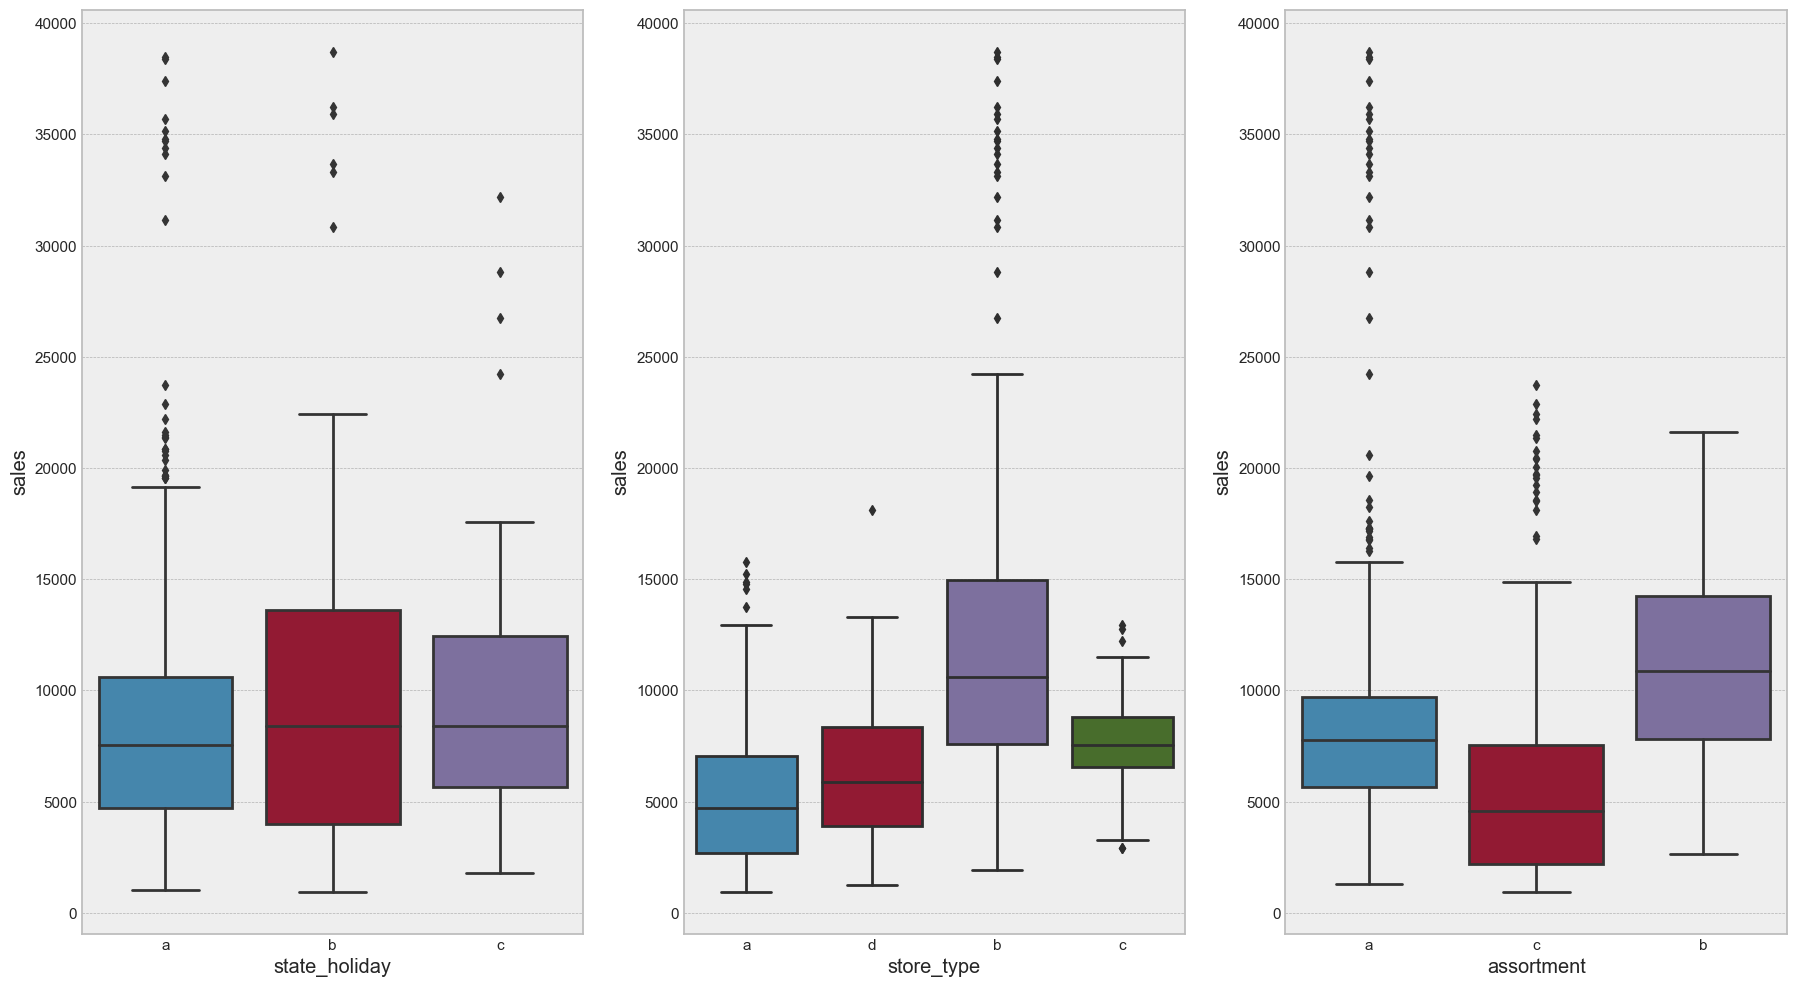

In [39]:
aux = df1[(df1['sales'] > 0) & (df1['state_holiday'] != '0')]

plt.subplot (1,3,1)
sns.boxplot (x = 'state_holiday', y= 'sales', data = aux);

plt.subplot (1,3,2)
sns.boxplot (x = 'store_type', y= 'sales', data = aux);

plt.subplot (1,3,3)
sns.boxplot (x = 'assortment', y= 'sales', data = aux);

# 2.0 Step 02 - FEATURE ENGINNEERING 

In [18]:
df2 = df1.copy()

## 2.1. Mind map hypotheses

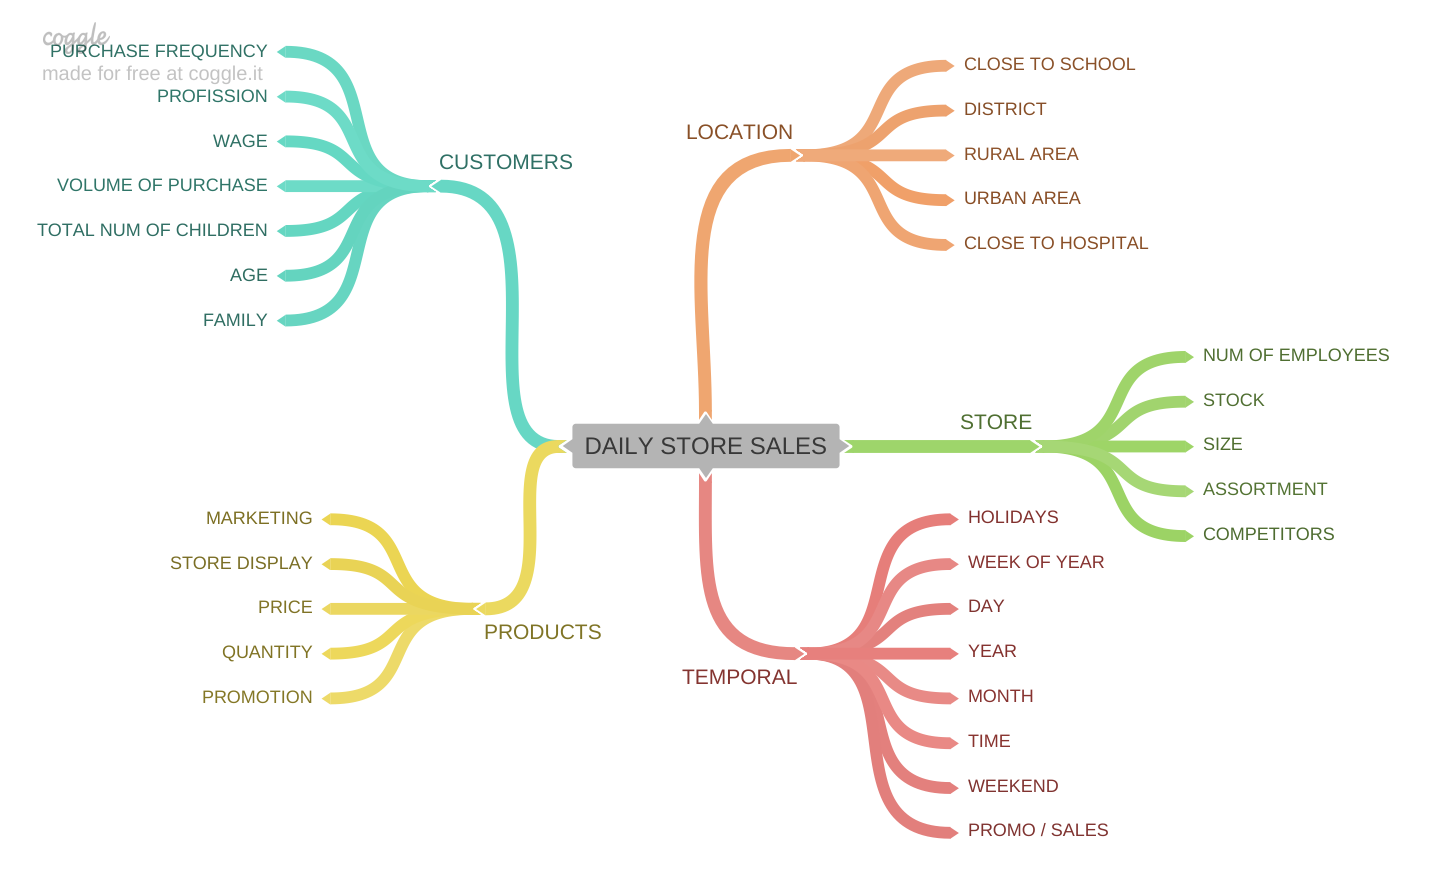

In [19]:
Image('./images/daily_store_sales.png')

### 2.1.1. Store hypotheses

**1.** Stores with more employees should sell more

**2.** Stores with greater stock capacity should sell more

**3.** Larger stores should sell more

**4.** Stores with greater assortment should sell more

**5.** Stores with closer competitors should sell less

**6.** Stores with longer competitors should sell more



### 2.1.2. Products hypotheses

**1.** Stores that invest more in marketing should sell more

**2.** Stores with greater product exposure should sell more

**3.** Stores with lower priced products should sell more

**4.** Stores with more aggressive promotions should sell more

**5.** Stores with longer active promotions should sell more

**6.** Stores with more days of promotion should sell more

**7.** Stores with more consecutive promotions should sell more

### 2.1.3. Temporal hypotheses

**1.** Stores open during the Christmas holiday should sell more

**2.** Stores should sell more over the years

**3.** Stores should sell more in the 2nd half of the year

**4.** Stores should sell more after the 10th of each month

**5.** Stores should sell less on weekends

**6.** Stores should sell less during school holidays

## 2.2 Prioritizing hypotheses

**1.** Stores with greater assortment should sell more

**2.** Stores with closer competitors should sell less

**3.** Stores with longer competitors should sell more

==============================================

**4.** Stores with longer active promotions should sell more

**5.** Stores with more days of promotion should sell more

**6.** Stores with more consecutive promotions should sell more

==============================================

**7.** Stores open during the Christmas holiday should sell more

**8.** Stores should sell more over the years

**9.** Stores should sell more in the 2nd half of the year

**10.** Stores should sell more after the 10th of each month

**11.** Stores should sell less on weekends

**12.** Stores should sell less during school holidays



## 2.3 Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month 

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis =1)

df2['competition_time_month'] = df2.apply(lambda x: ((x['date'] - x['competition_since'])/30).days, axis = 1).astype(np.int64)

# promo since
df2['promo_since'] = df2.apply(lambda x: str(x['promo2_since_year']) + '-' + str(x['promo2_since_week']), axis =1)

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime (x +'-1', '%Y-%W-%w')- datetime.timedelta(days=7) )

df2['promo_time_week'] = df2.apply(lambda x: ((x['date'] - x['promo_since'])/7).days, axis = 1).astype(np.int64)

# assortment 
df2['assortment'] = df2['assortment'].apply (lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended') 

# state holiday 
df2['state_holiday'] = df2['state_holiday'].apply (lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day') 


#  3.0 Step 03 - VARIABLE FILTERING

In [21]:
df3 = df2.copy()

## 3.1 Rows Selection

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [23]:
cols_drop = ['customers','open','month_map', 'date_max', 'promo_interval']

df3.drop(cols_drop,axis=1, inplace= True)

# 4.0 Step 04 - EXPLORATORY DATA ANALYSIS

In [24]:
df4 = df3.copy()
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.1 Univariate Analysis

### 4.1.1 Response variable

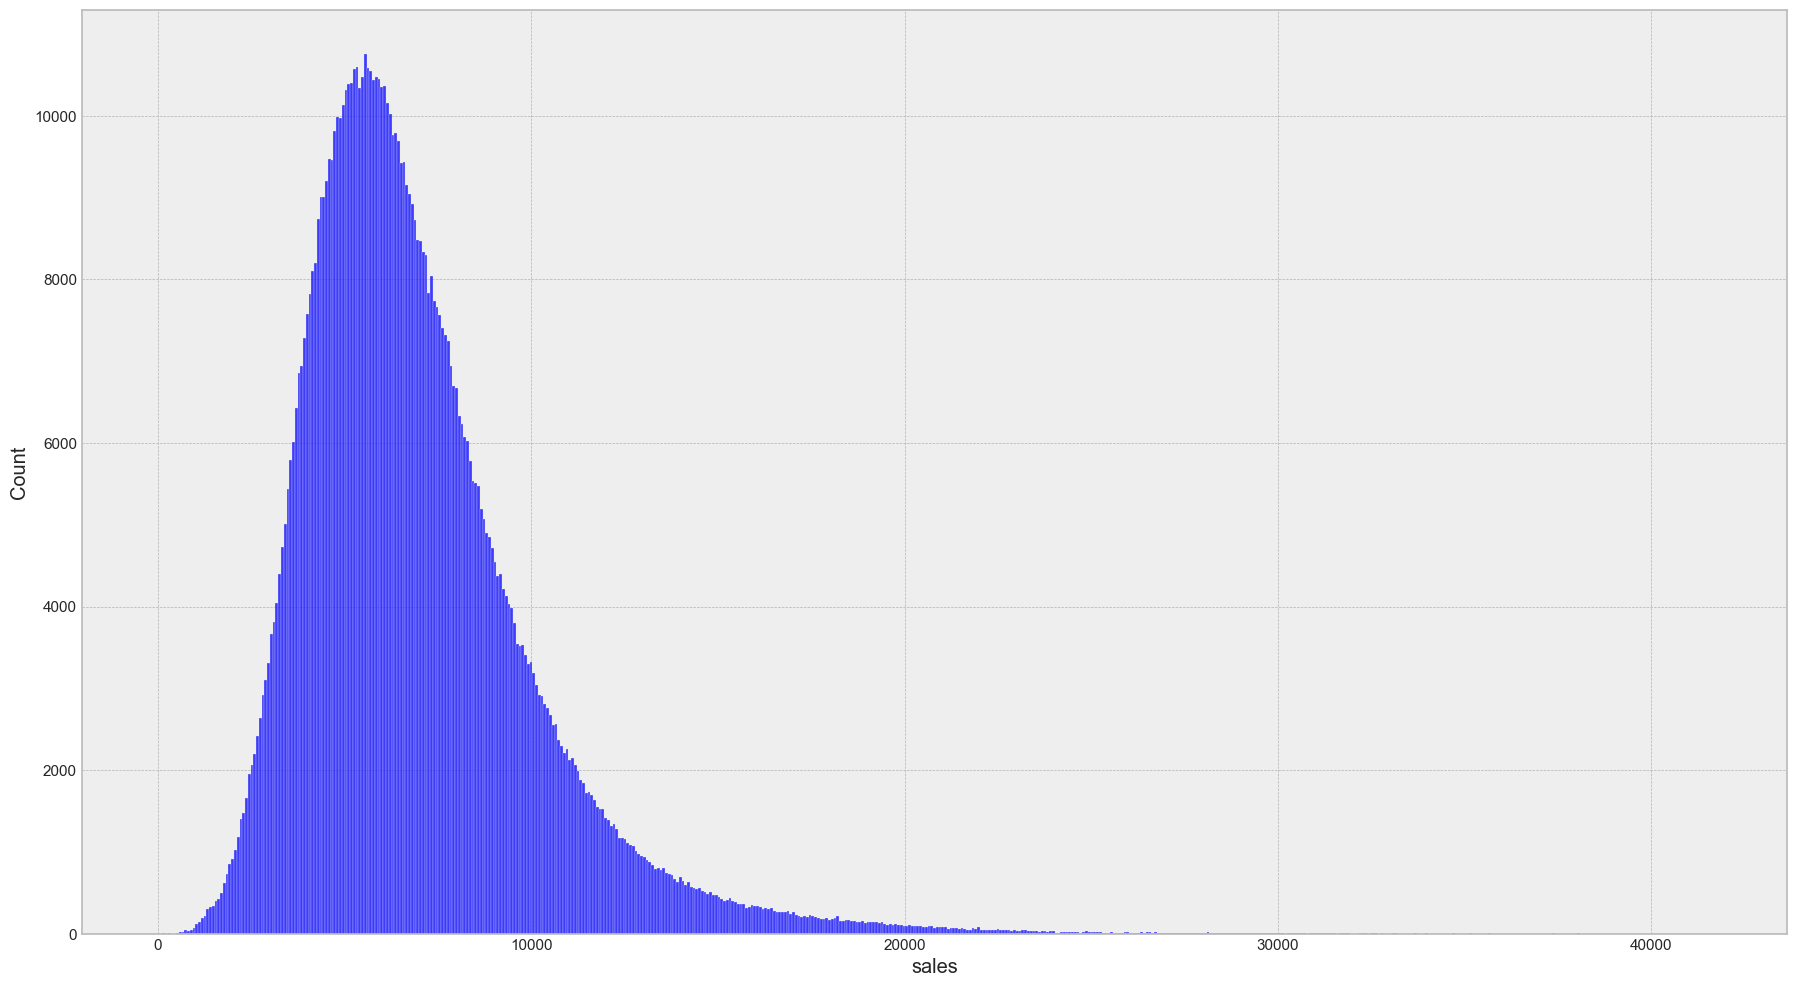

In [40]:
sns.histplot(df4['sales']);

### 4.1.2 Numerical variable

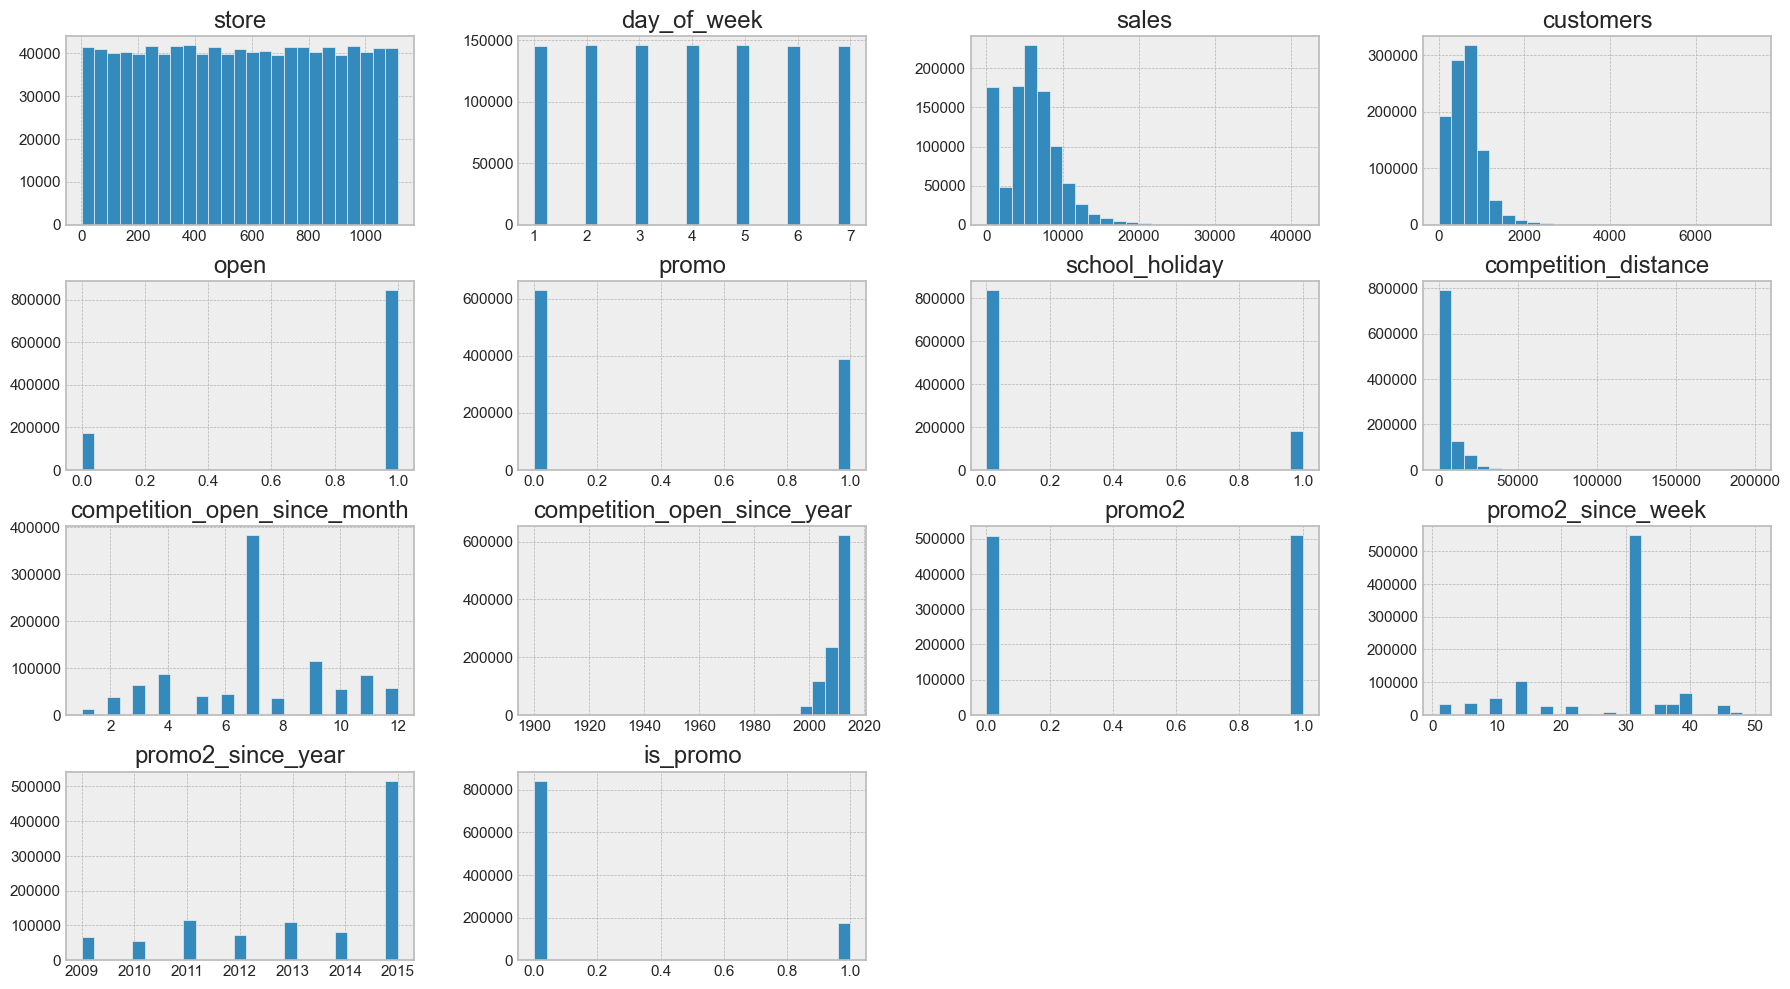

In [41]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical variable

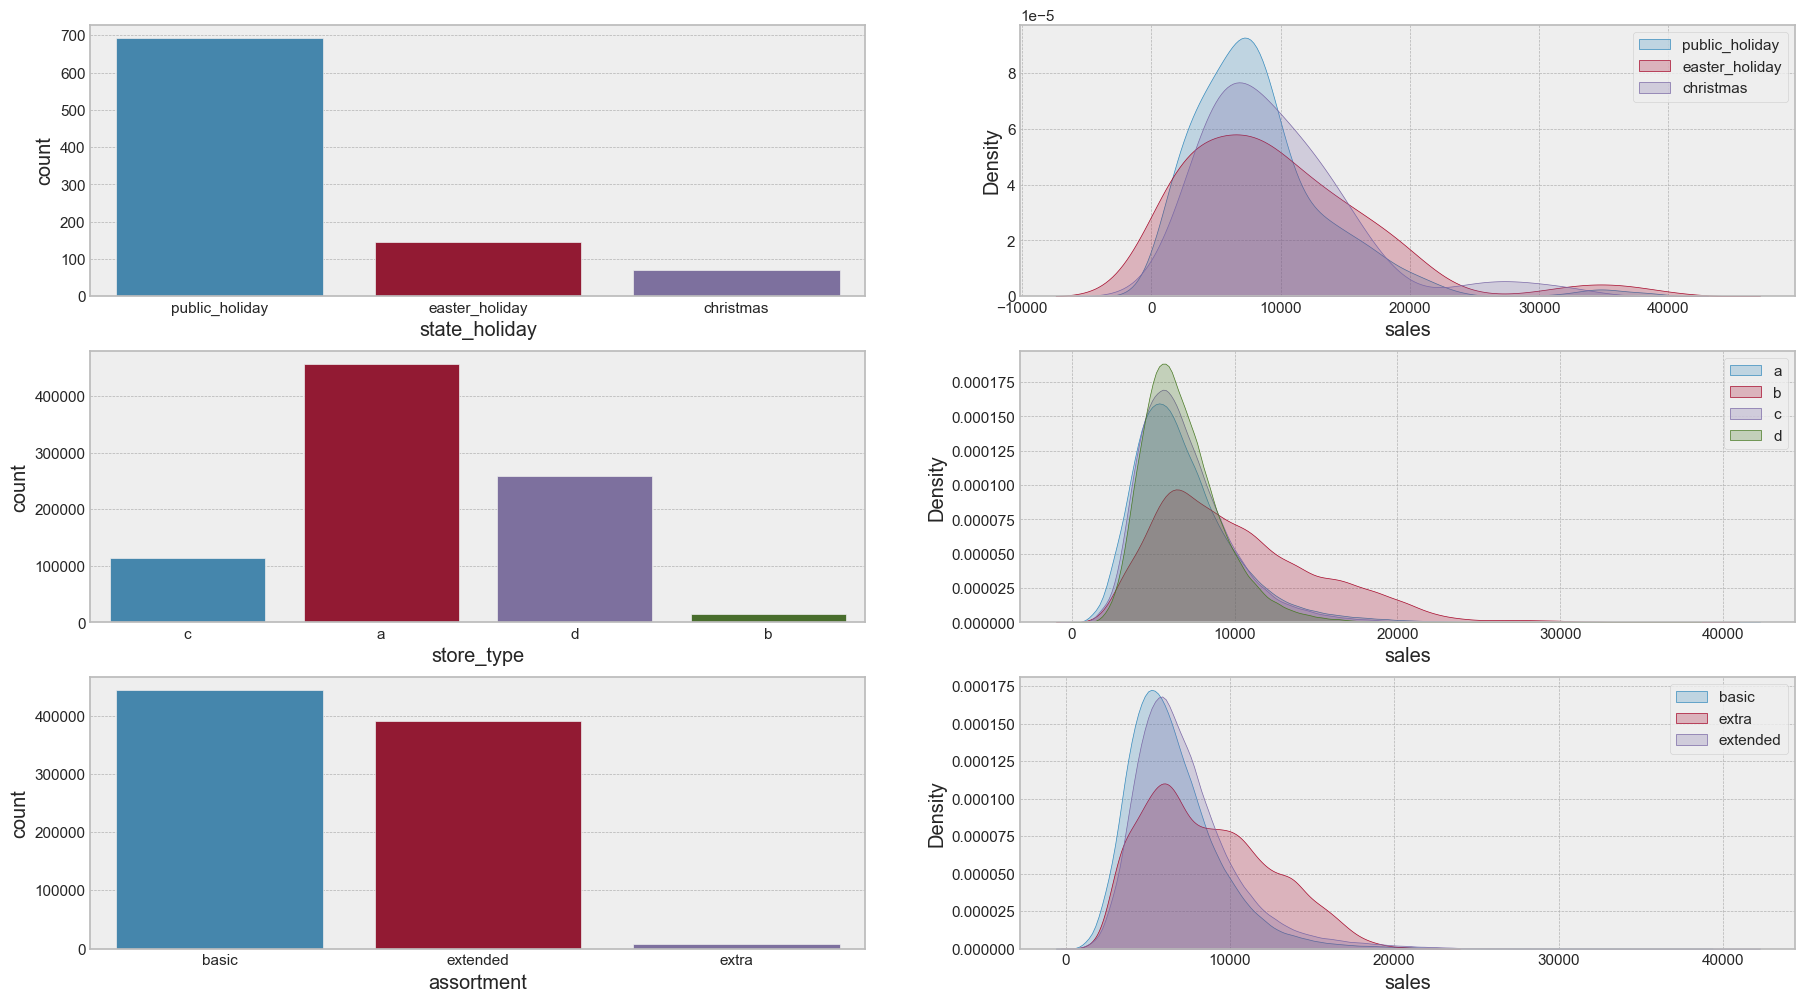

In [42]:
# state holiday
plt.subplot(3,2,1)
a1 = df4[df4['state_holiday']!= 'regular_day']
sns.countplot(a1['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade= True);
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade= True);
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade= True);
plt.legend();

# store type
plt.subplot(3,2,3)
sns.countplot(df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label = 'a', shade= True);
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label = 'b', shade= True);
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label = 'c', shade= True);
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label = 'd', shade= True);
plt.legend();

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade= True);
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade= True);
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade= True);
plt.legend();





## 4.2 Bivariate Analysis

### H1. Stores with greater assortement should sell more

**FALSE** - Extended assortement sell less than extra assortment.


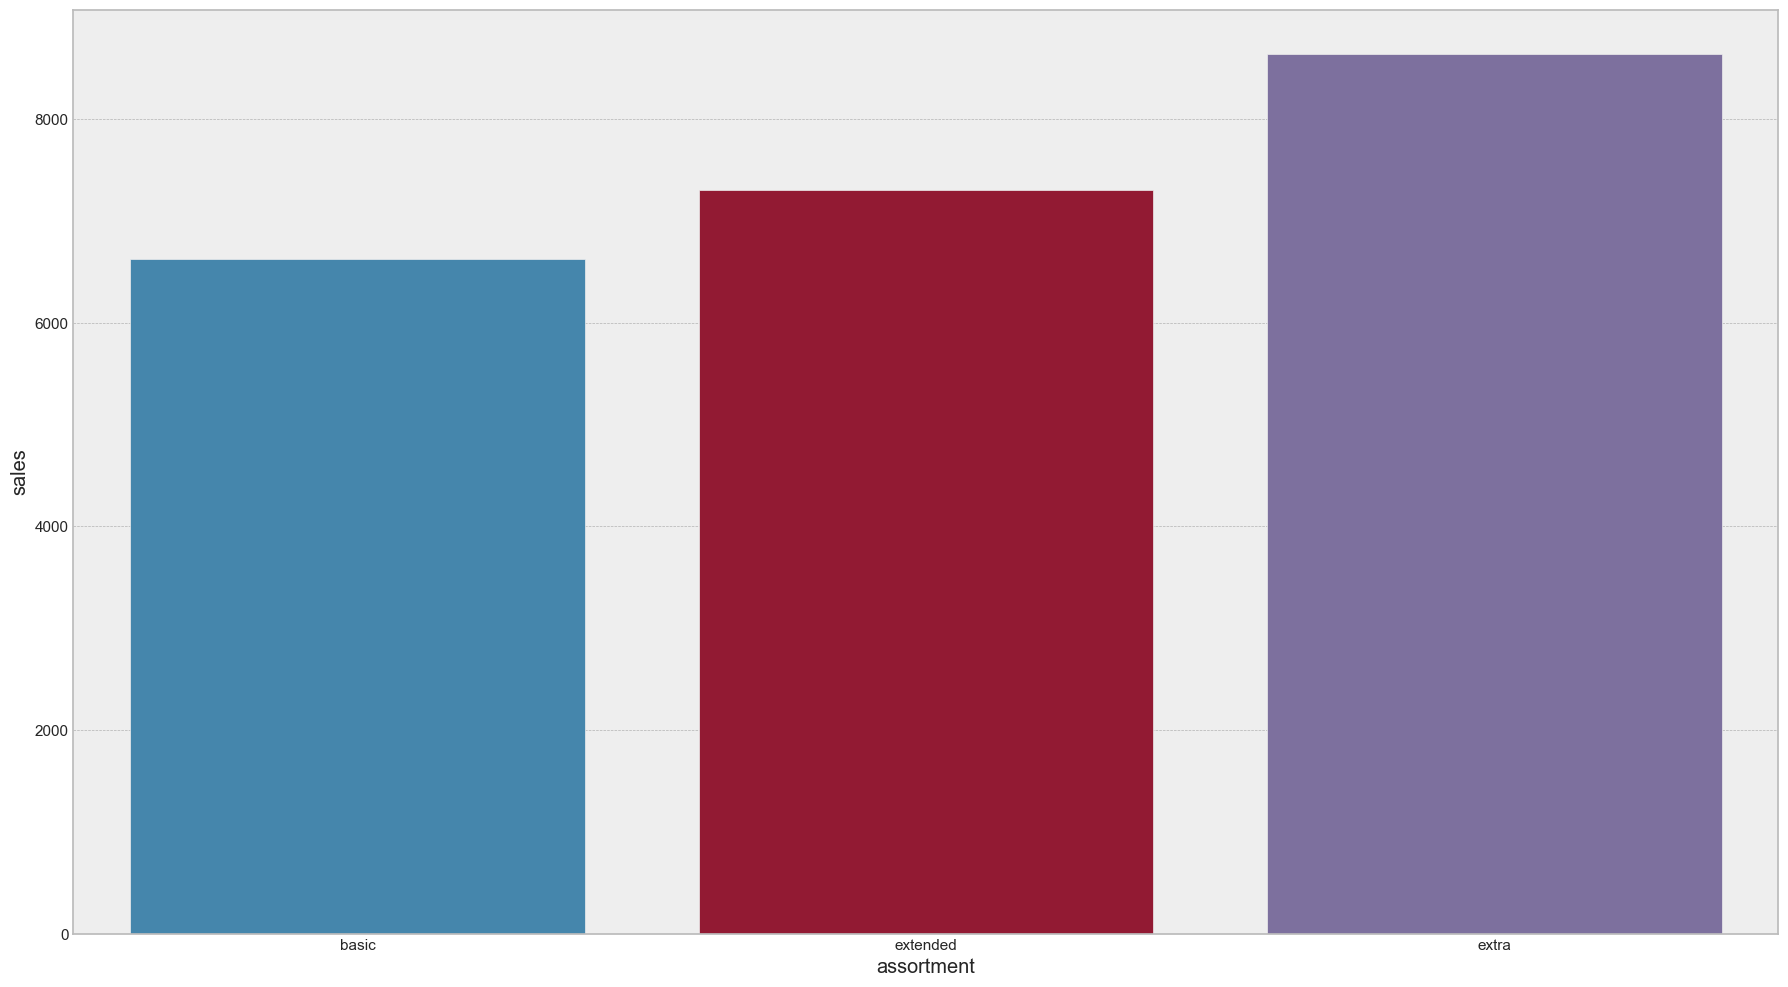

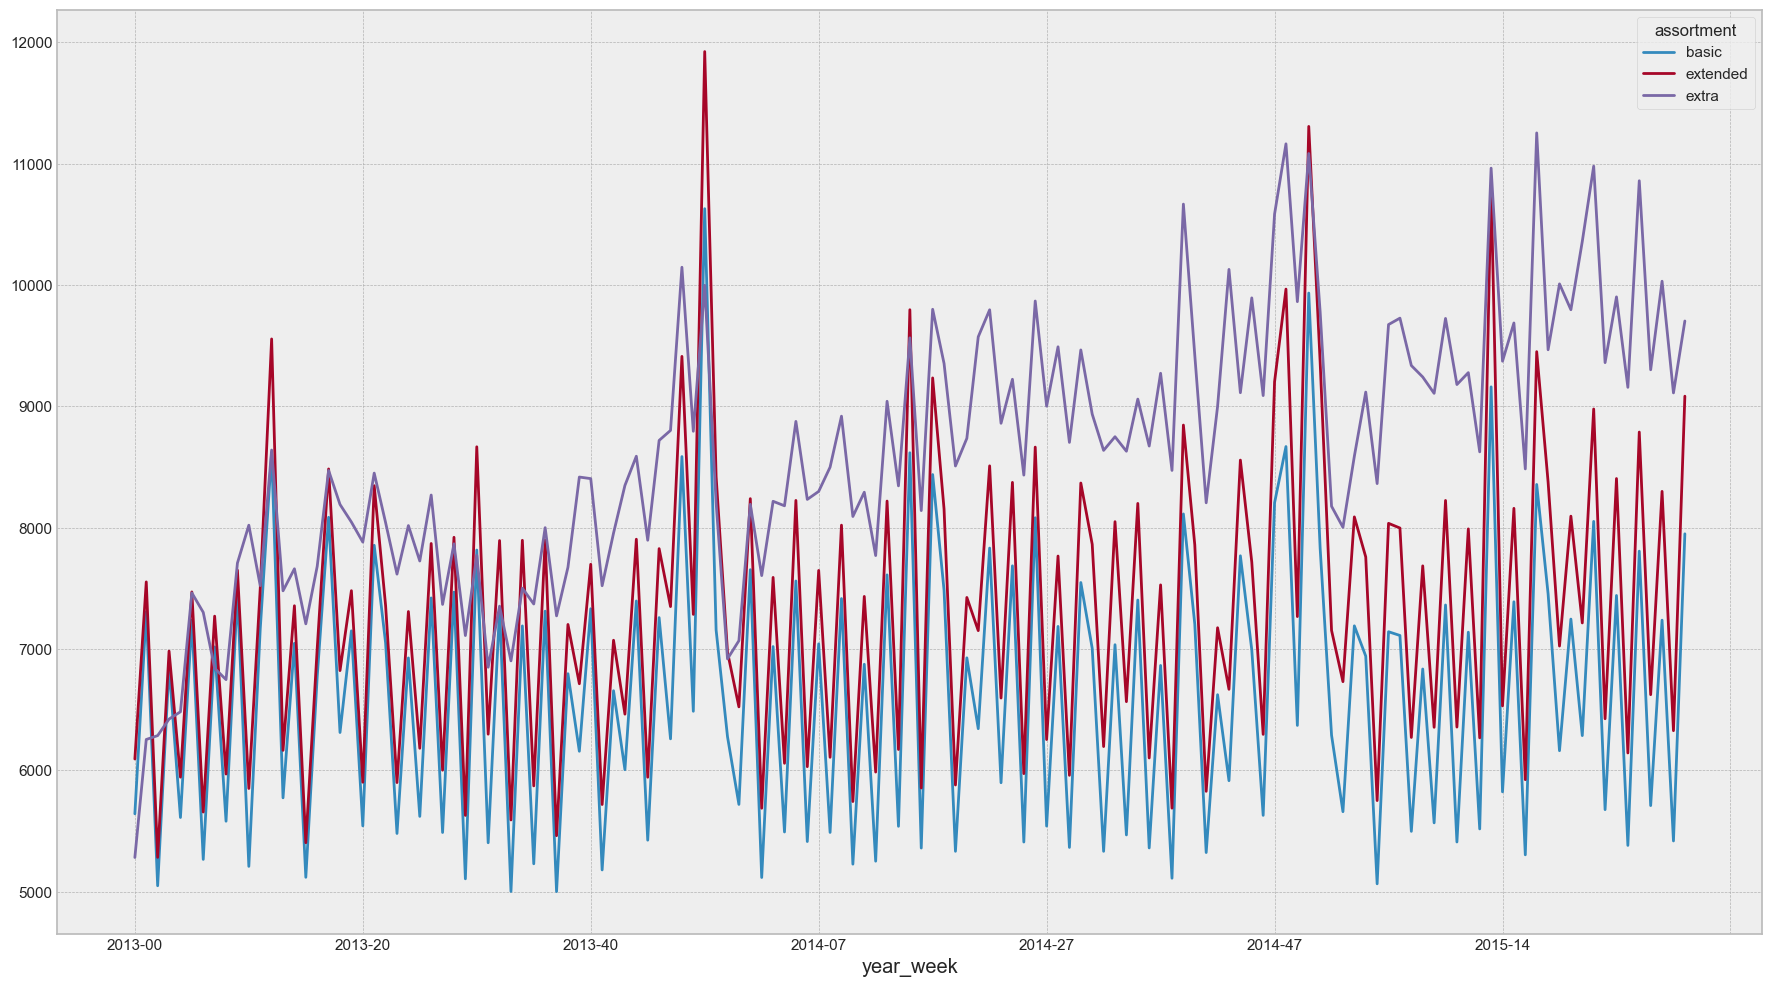

In [43]:
aux = df4.groupby('assortment',as_index=False).mean()[['assortment','sales']]
sns.barplot(x = 'assortment', y = 'sales', data = aux);

aux1 = df4.groupby(['year_week','assortment'], as_index=False).mean()[['year_week','assortment', 'sales']]
aux1.pivot( index='year_week', columns = 'assortment', values = 'sales').plot();


### H2.  Stores with closer competitors should sell less

**FALSE** Stores with CLOSER COMPETITORS sell MORE



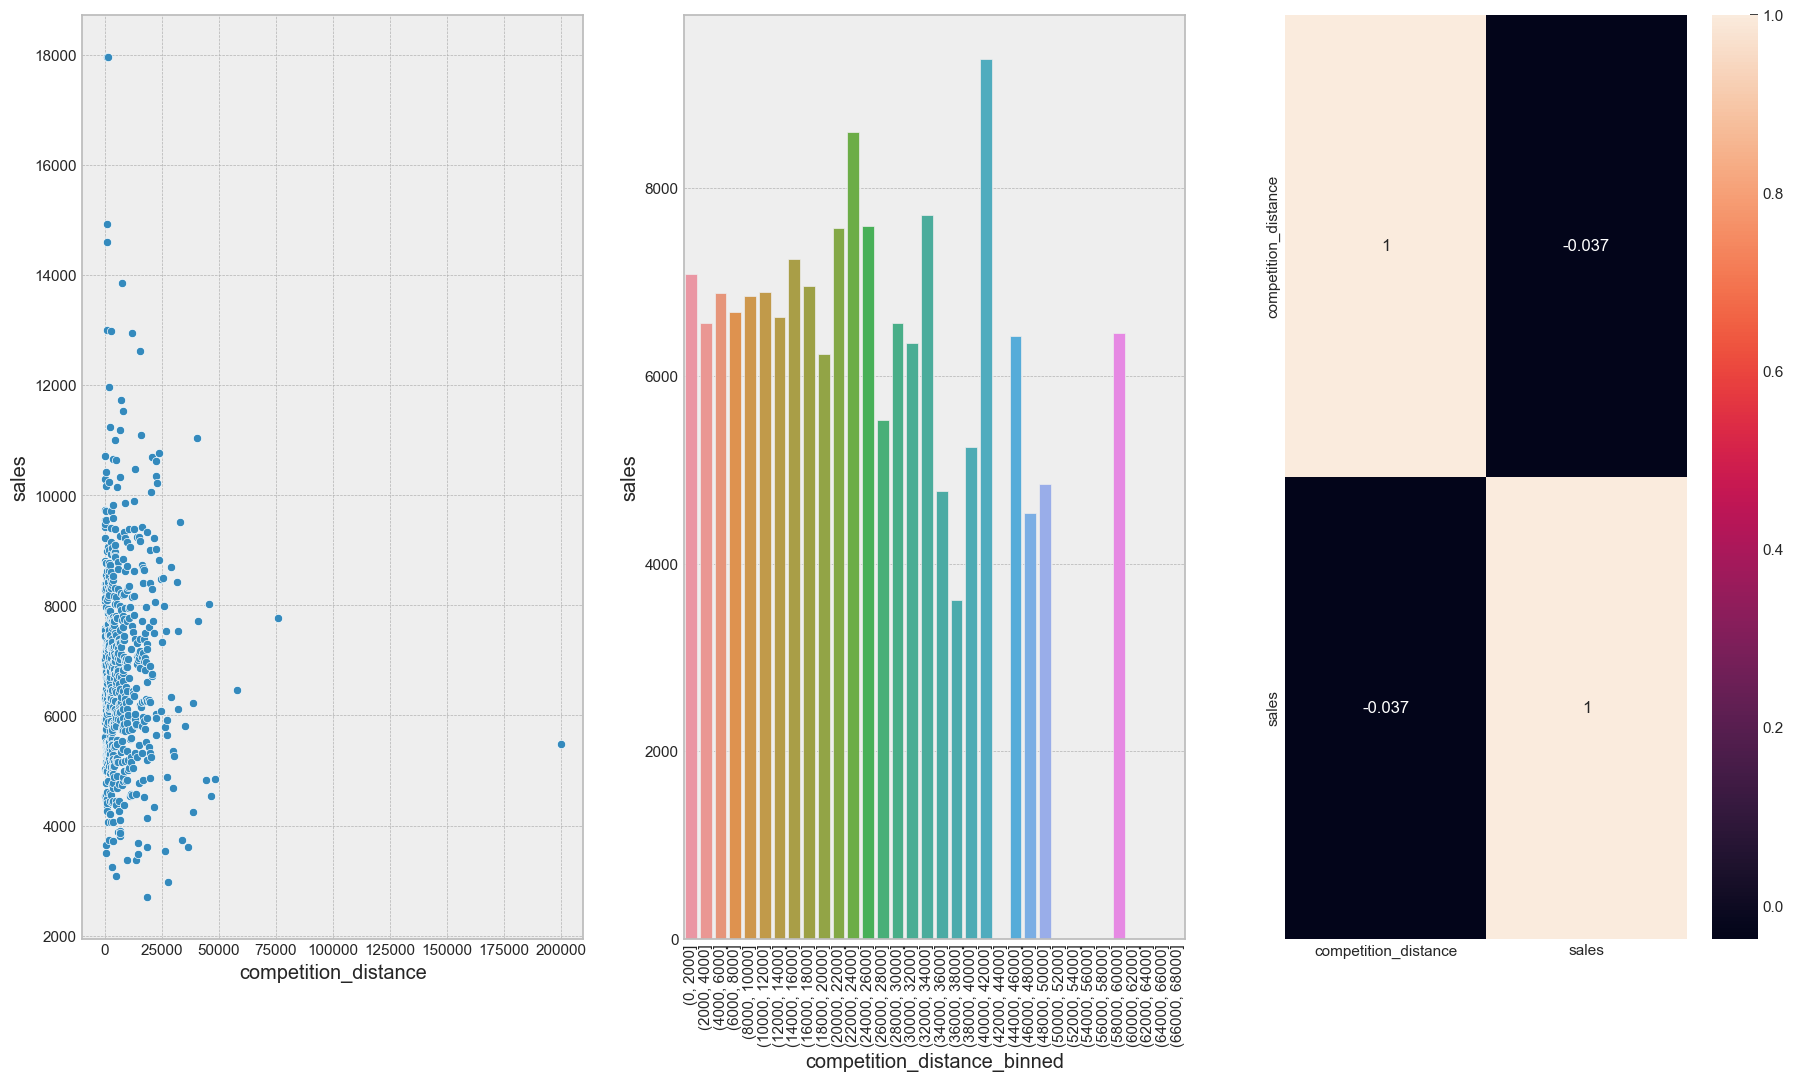

In [44]:
aux = df4.groupby('competition_distance',as_index=False).mean()[['competition_distance','sales']]

plt.subplot(1,3,1)
sns.scatterplot (x='competition_distance', y='sales', data=aux);

plt.subplot(1,3,2)
bins = list (np.arange(0, 70000, 2000))
aux['competition_distance_binned'] = pd.cut(aux['competition_distance'], bins = bins)
aux1 = aux.groupby('competition_distance_binned', as_index=False).mean()[['competition_distance_binned','sales']]
sns.barplot( x = 'competition_distance_binned', y = 'sales', data = aux1);
plt.xticks (rotation = 90);

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True);



### H.3 Stores with longer competitors should sell more

**FALSE** Stores with LONGER COMPETITORS sell LESS

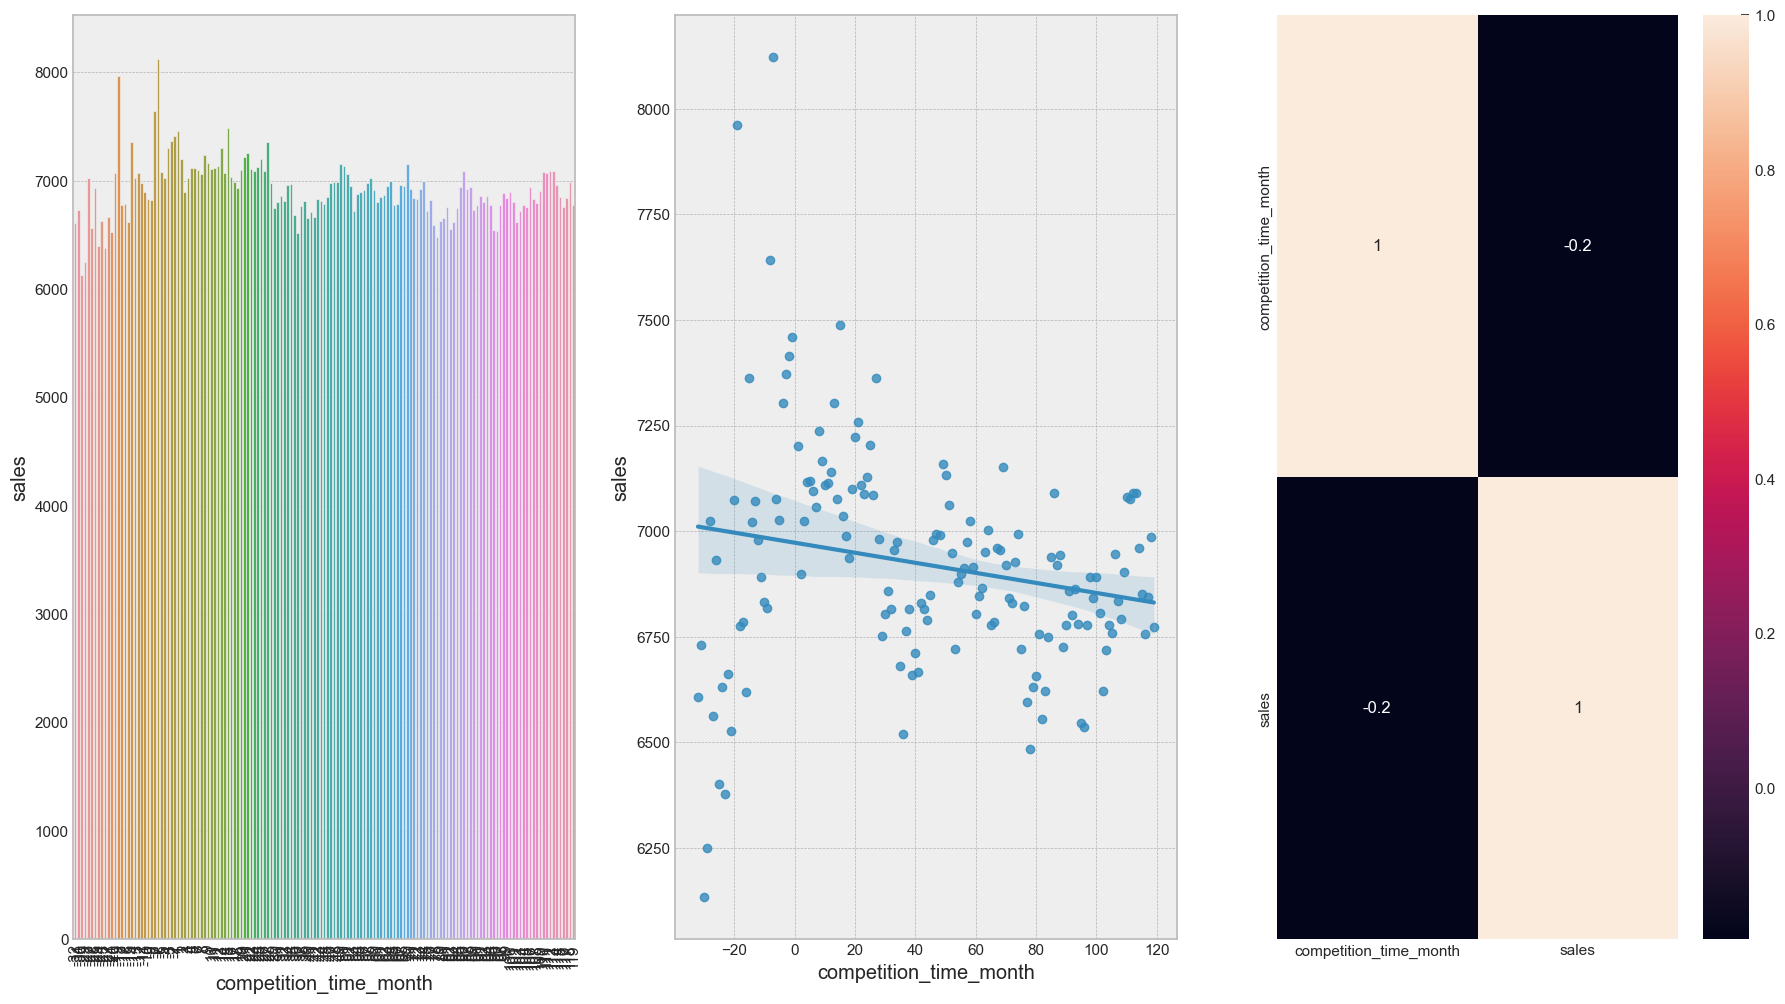

In [45]:
aux = df4.groupby('competition_time_month', as_index=False).mean()[['competition_time_month', 'sales']]

plt.subplot(1,3,1)
aux1 = aux[(aux['competition_time_month']<120) & (aux['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux1);
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot=True);



### H.4 Stores with longer active promotions should sell more
**TRUE** Stores with LONGER ACTIVE PROMOTIONS sell MORE

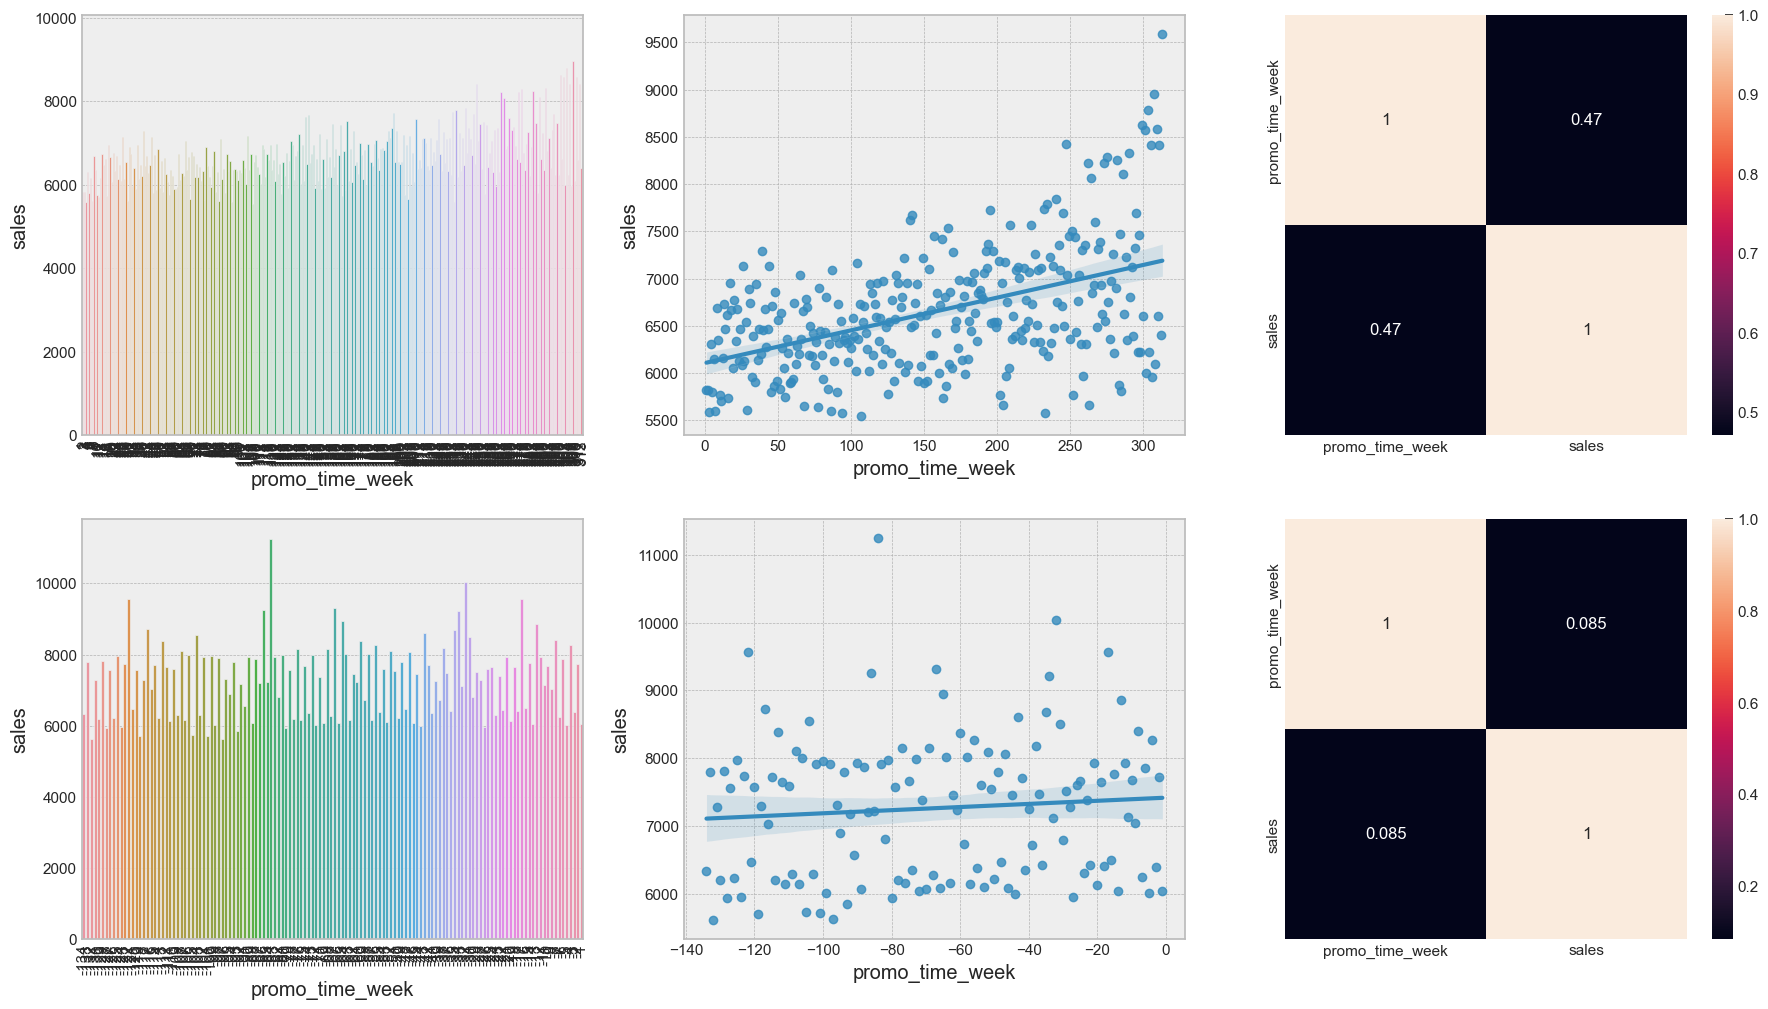

In [46]:
aux = df4.groupby('promo_time_week', as_index=False).mean()[['promo_time_week','sales']]

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux1 = aux[aux['promo_time_week']>0] # promo extended
sns.barplot( x='promo_time_week', y='sales', data=aux1);
plt.xticks( rotation=90);

plt.subplot(grid[0,1])
sns.regplot( x='promo_time_week', y='sales', data=aux1);

plt.subplot(grid[1,0])
aux2 = aux[aux['promo_time_week']<0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux2);
plt.xticks( rotation=90);

plt.subplot(grid[1,1])
sns.regplot( x='promo_time_week', y='sales', data=aux2);


plt.subplot(grid[0,2]) # promo extended
sns.heatmap( aux1.corr(method='pearson'), annot=True);


plt.subplot(grid[1,2]) # promo regular
sns.heatmap( aux2.corr(method='pearson'), annot=True);


### <s>H.5 Stores with more days of promotion should sell more<s>


### H.6 Stores with more consecutive promotions should sell more
**FALSE** Stores with both promo and promo2 sell less than stores with promo


In [54]:
df4.groupby(['promo','promo2'], as_index=False).mean()[['promo','promo2','sales']]


,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


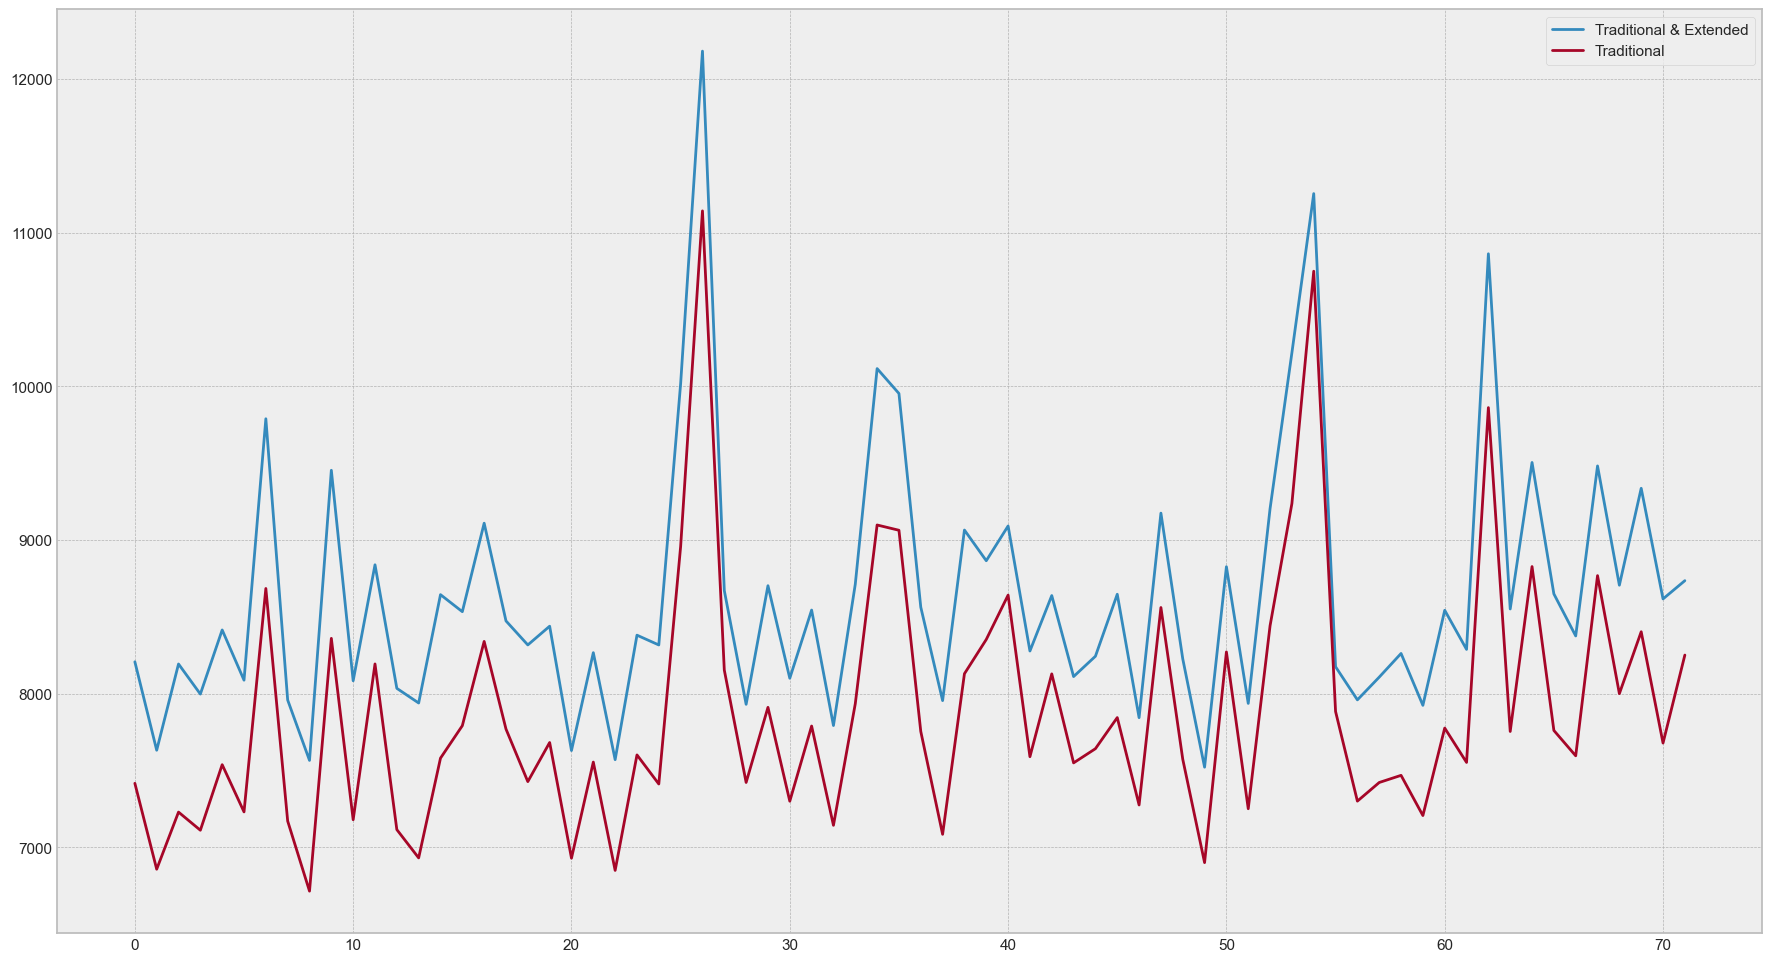

In [55]:
aux = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').mean().reset_index()
ax = aux.plot();

aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux1.plot(ax=ax);

ax.legend (labels = ['Traditional & Extended', 'Traditional']);


### H.7 Stores open during the Christmas holiday should sell more
**TRUE** Stores open during the Christmas holiday sell more than public holidays and regular days

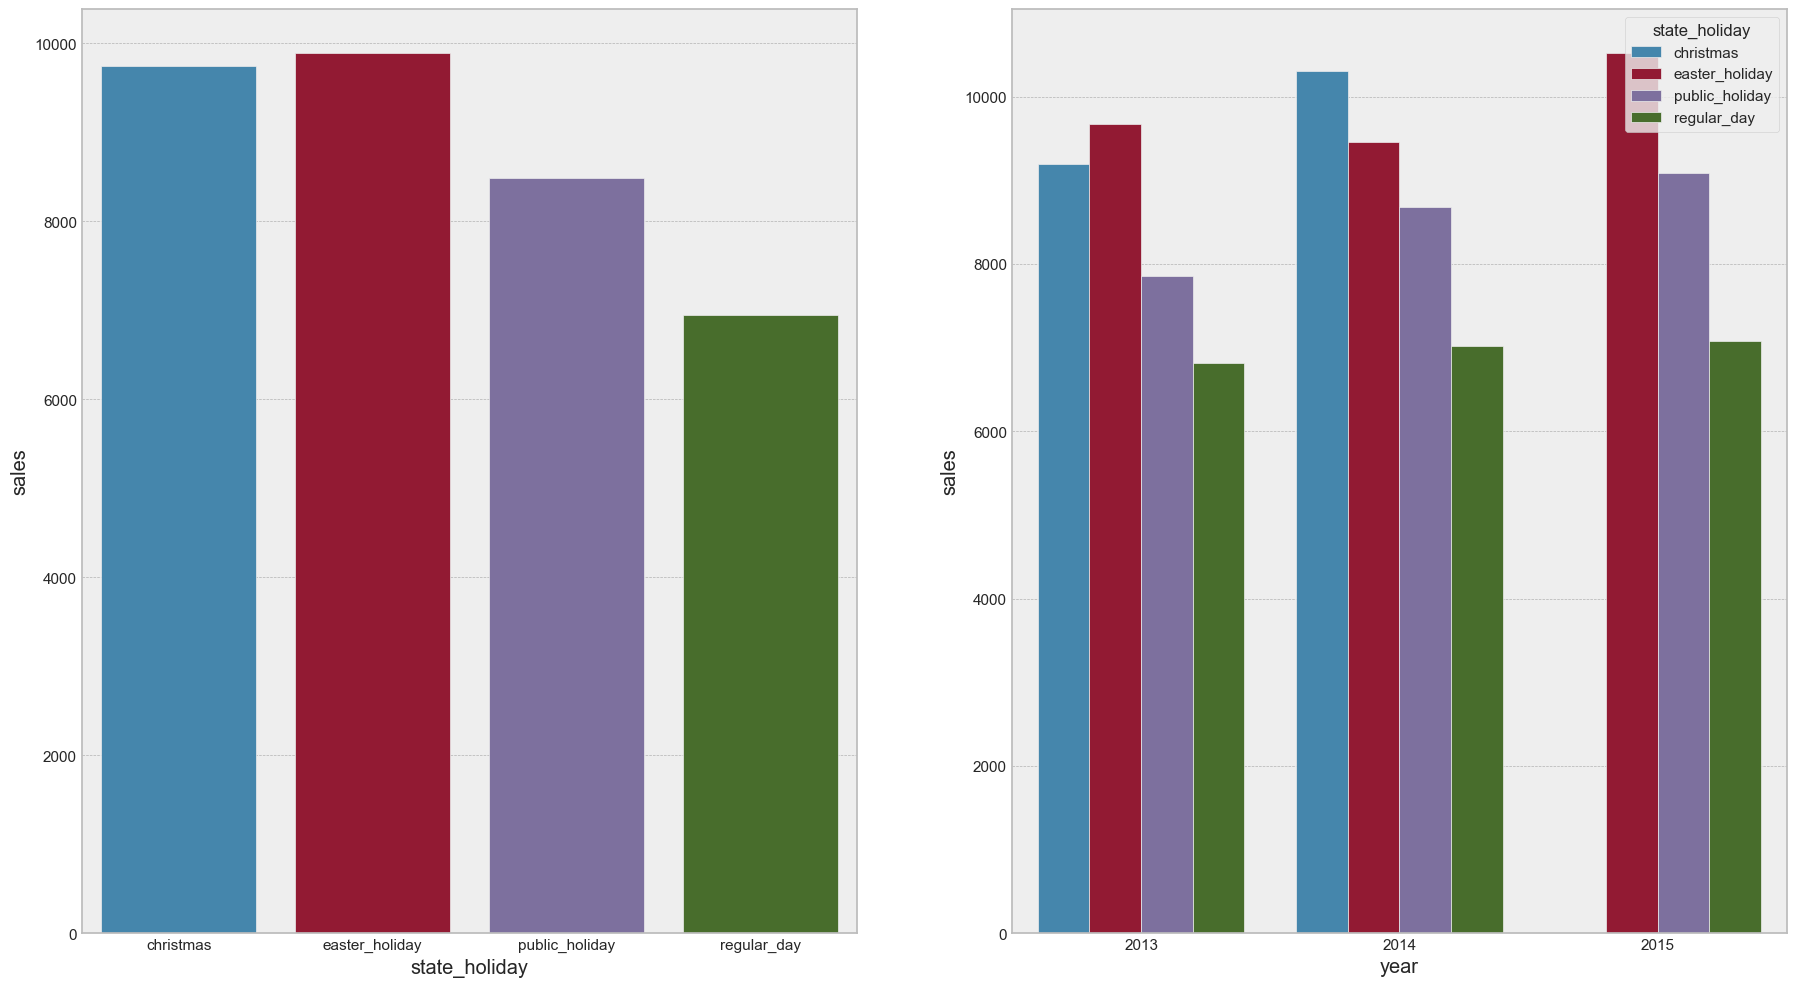

In [56]:
plt.subplot(1,2,1)
aux = df4[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data = aux);

plt.subplot(1,2,2)
aux1 = df4[['year', 'state_holiday','sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue ='state_holiday', data=aux1);

### H.8 Stores should sell more over the years
**TRUE** Stores sell more over the years


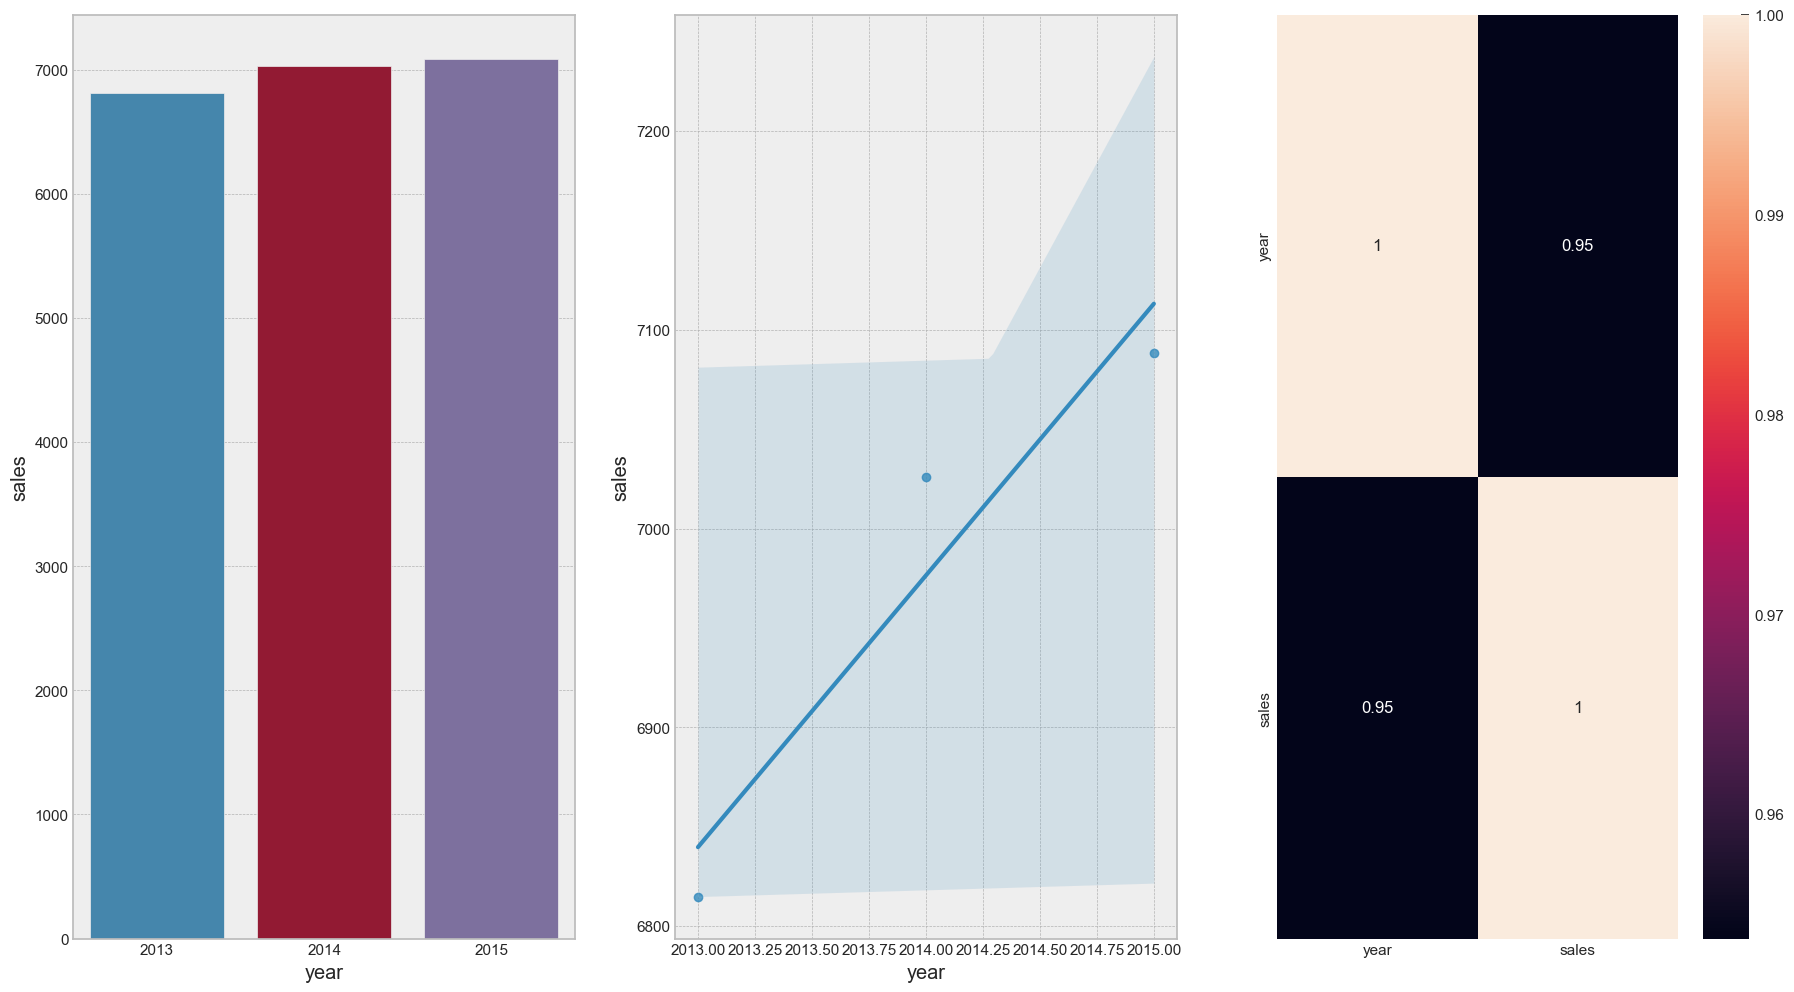

In [57]:
aux = df4[['year','sales']].groupby('year').mean().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux);

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'),annot= True );

### H.9 Stores should sell more in the 2nd half of the year
**TRUE** Stores sell more int the 2nd half of the year

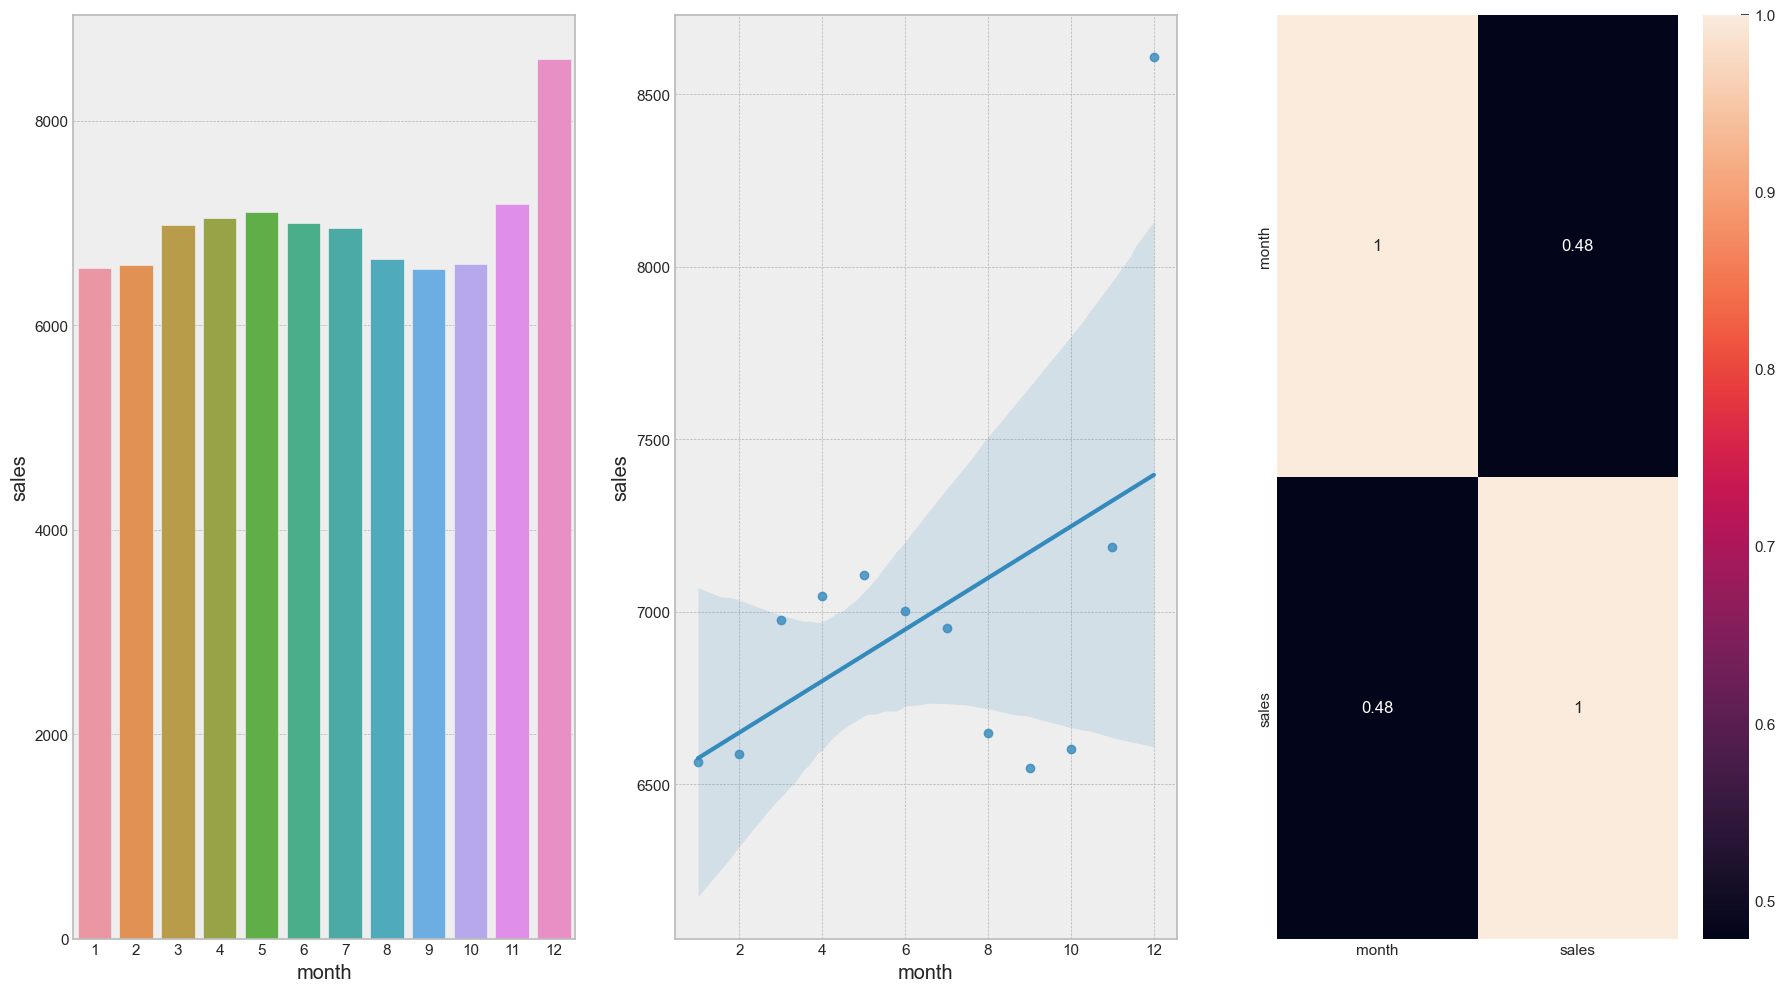

In [58]:
aux = df4[['month','sales']].groupby('month').mean().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux);

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'),annot= True );

### H.10 Stores should sell more after the 10th of each month
**FALSE** Stores sell less after the 10th of each month

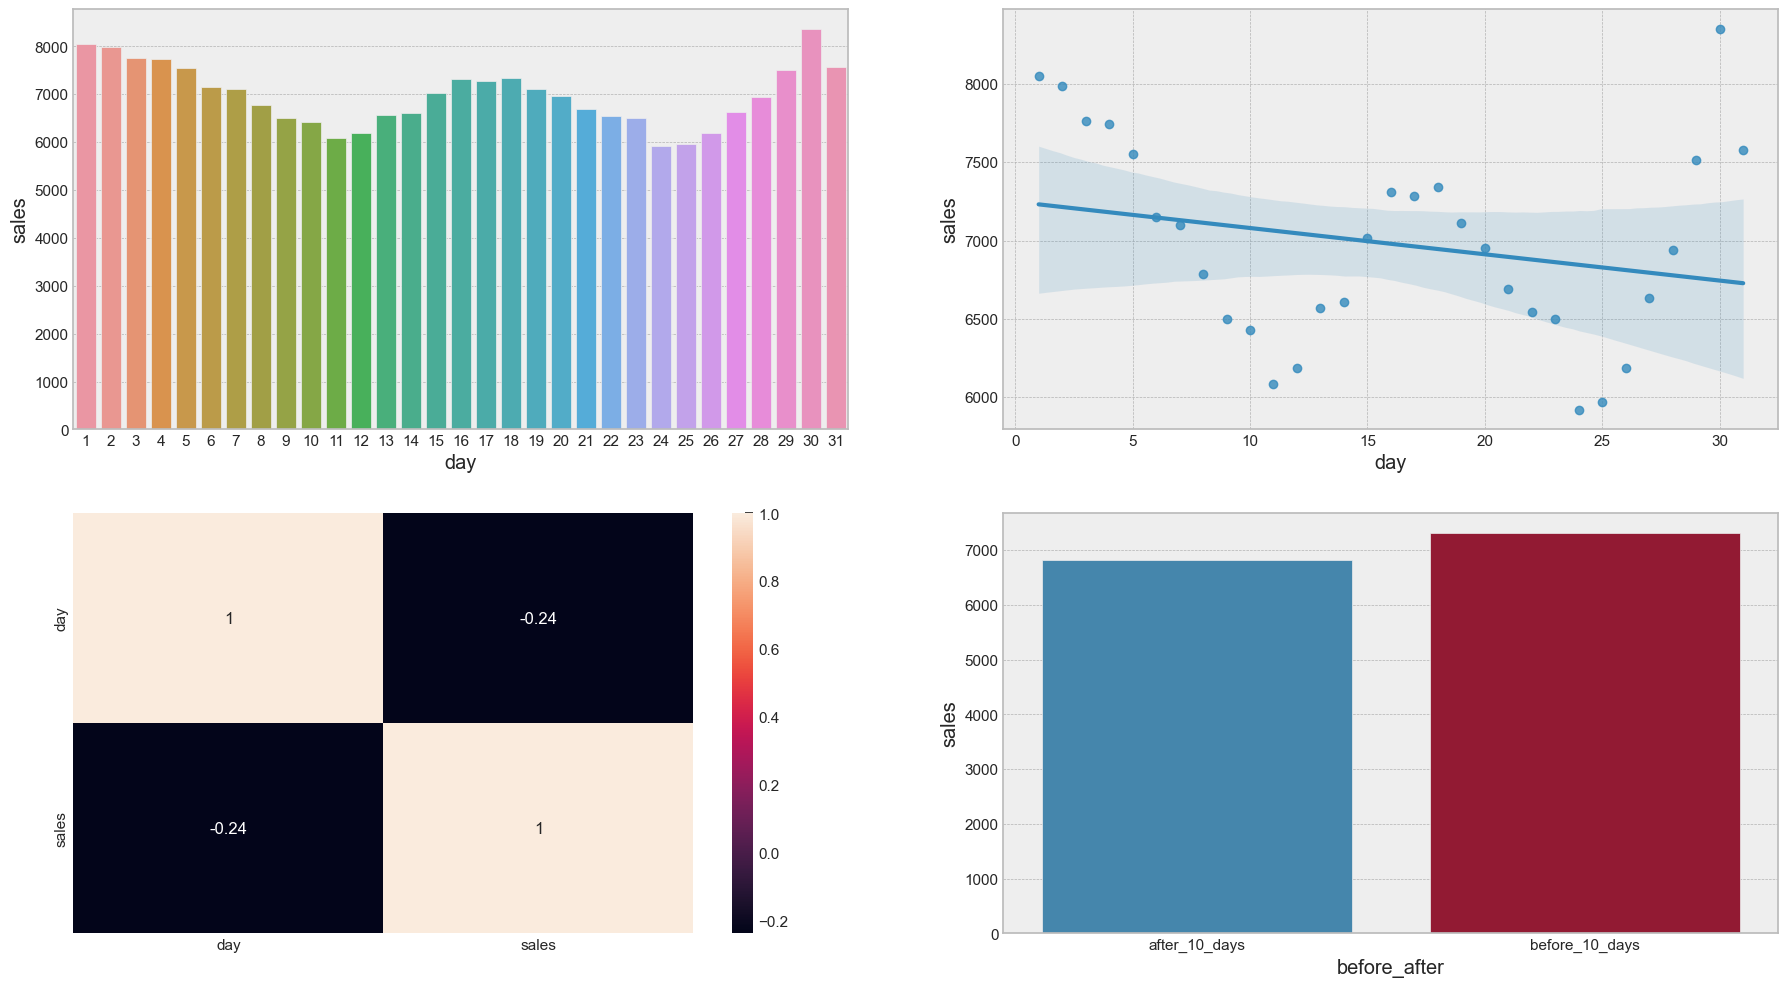

In [59]:
aux = df4[['day','sales']].groupby('day').mean().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux);

plt.subplot(2,2,3)
sns.heatmap(aux.corr(method='pearson'),annot= True );

aux['before_after'] = aux['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

plt.subplot(2,2,4)
aux1 = aux[['before_after','sales']].groupby('before_after').mean().reset_index()
sns.barplot(x ='before_after', y='sales', data=aux1);

### H.11 Stores should sell less on weekends
**TRUE** Stores sell less on weekends

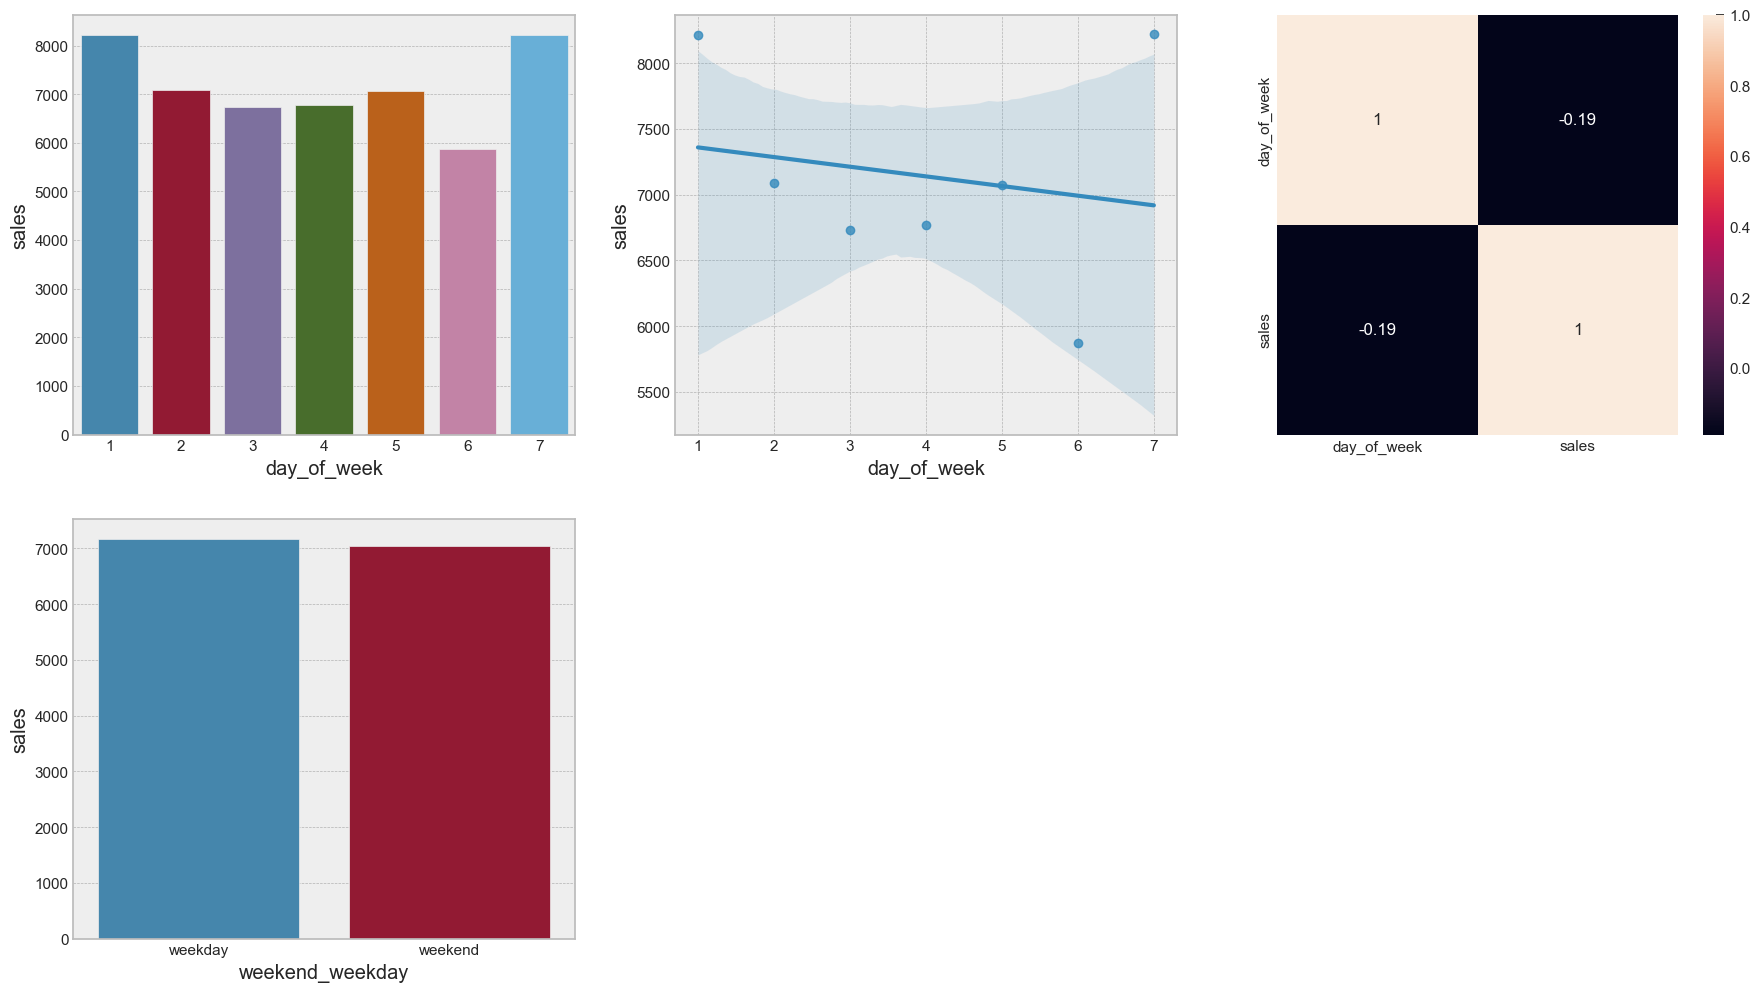

In [60]:
aux = df4[['day_of_week','sales']].groupby('day_of_week').mean().reset_index()

plt.subplot(2,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux);

plt.subplot(2,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux);

plt.subplot(2,3,3)
sns.heatmap(aux.corr(method='pearson'),annot= True );

plt.subplot(2,3,4)
aux['weekend_weekday'] = aux['day_of_week'].apply(lambda x: 'weekday' if x <= 5 else 'weekend')
aux1 = aux.groupby('weekend_weekday', as_index=False).mean()[['weekend_weekday','sales']]
sns.barplot(x='weekend_weekday', y='sales', data=aux1);


### H.12. Stores should sell less during school holidays
**FALSE** Stores sell more during school holidays

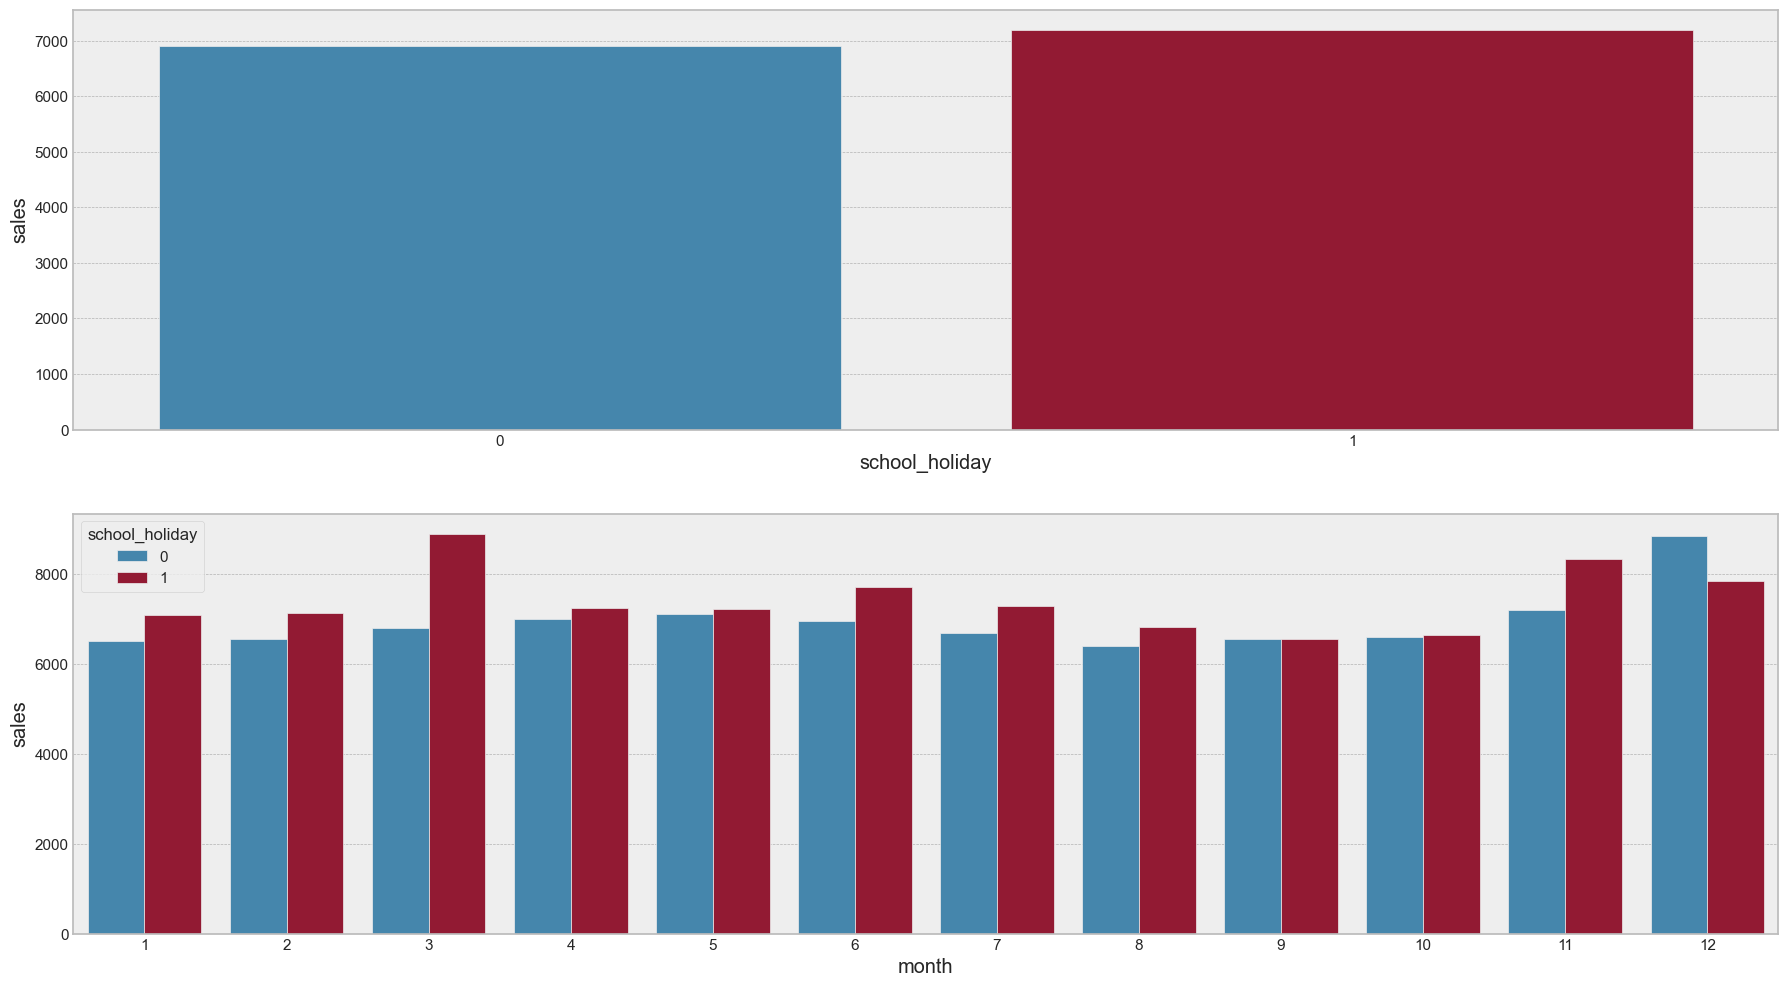

In [61]:
aux = df4[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux);

aux1= df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).mean().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux1);

### 4.2.1. Summary of hyphoteses 

| Hyphotesis | Conclusion | Relevance |
| :--------- | ---------- |----------:|
| H1         | False      | Medium    |
| H2         | False      | Medium    |
| H3         | False      | Medium    |
| H4         | True       | Medium    |
| H5         |    -       |     -     |
| H6         | False      | Hight     |
| H7         | True       | Medium    |
| H8         | True       | Hight     |
| H9         | True       | Hight     |
| H10        | False      | Hight     |
| H11        | True       | Medium    |
| H12        | False      | Low       |


## 4.3 Multivariate Analysis

### 4.3.1. Numerical Attributes

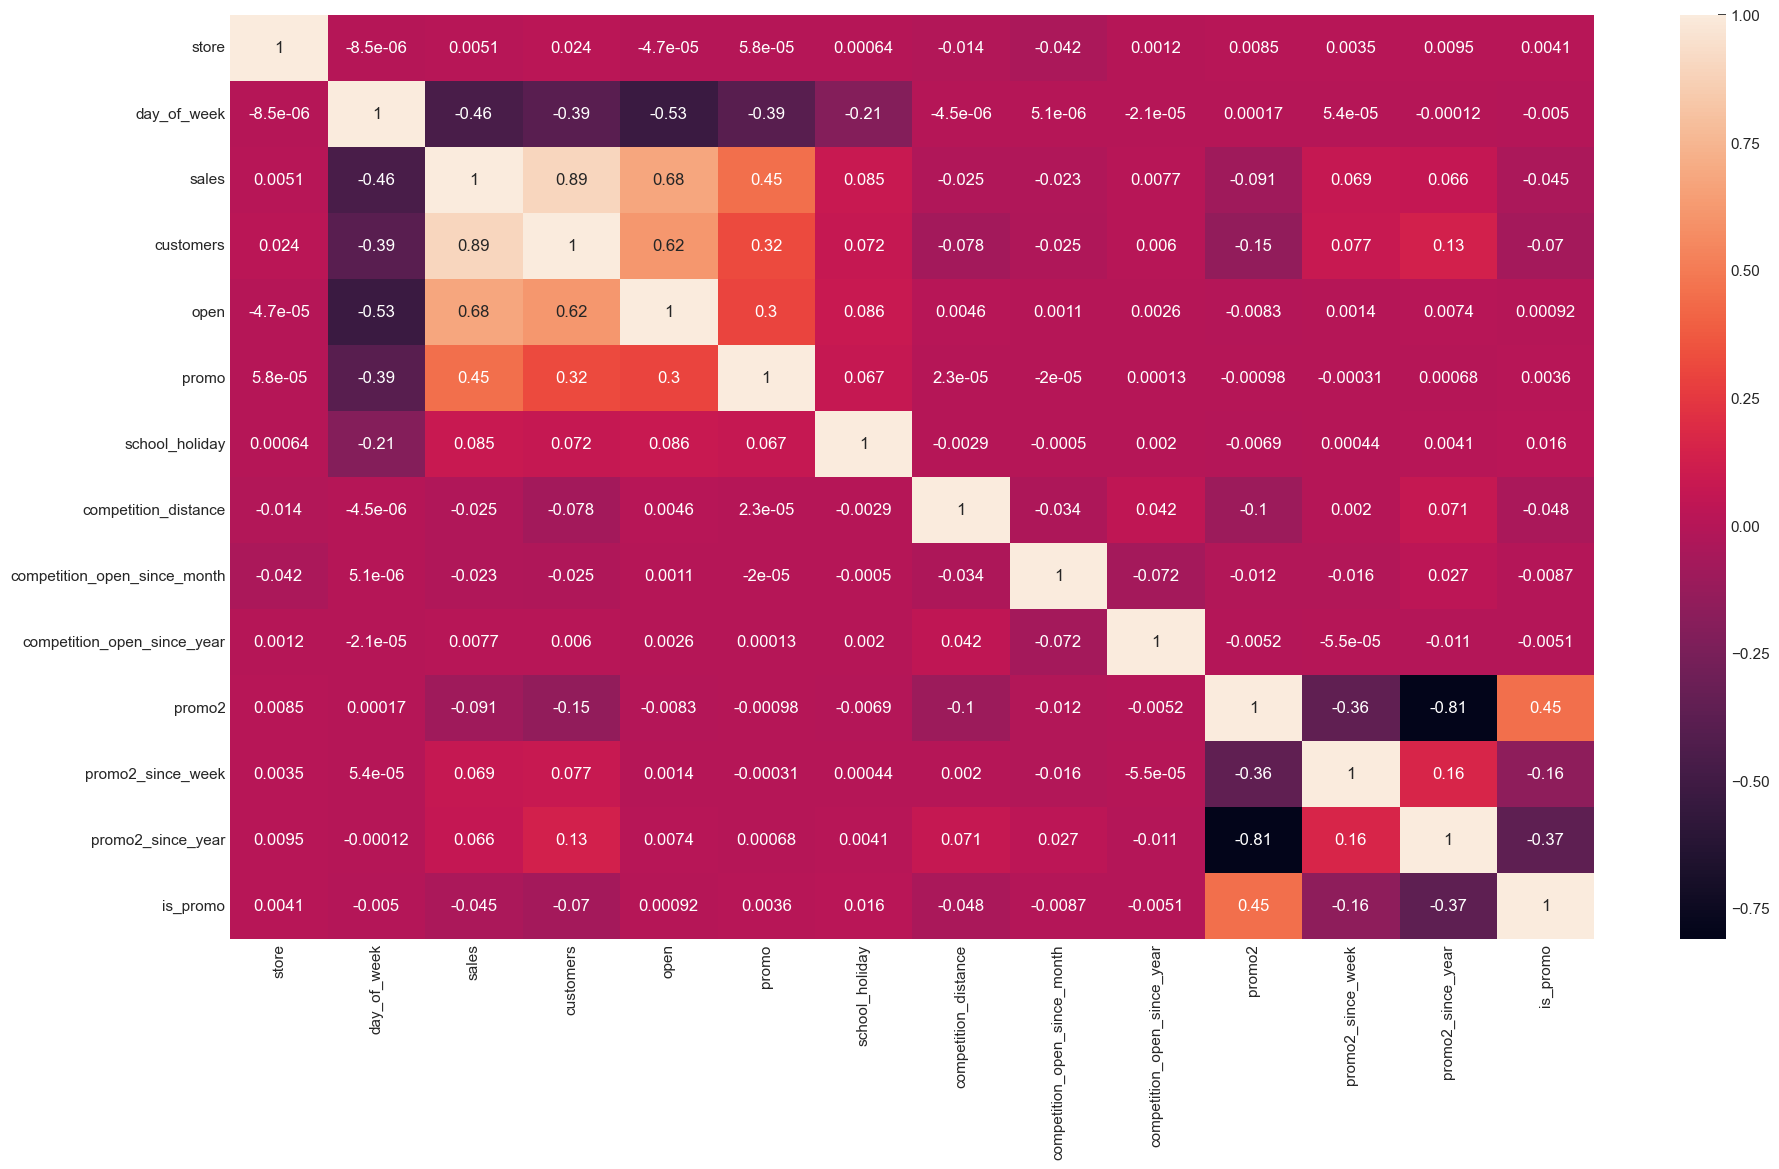

In [62]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap (correlation, annot=True);

### 4.3.2. Categorical Attributes

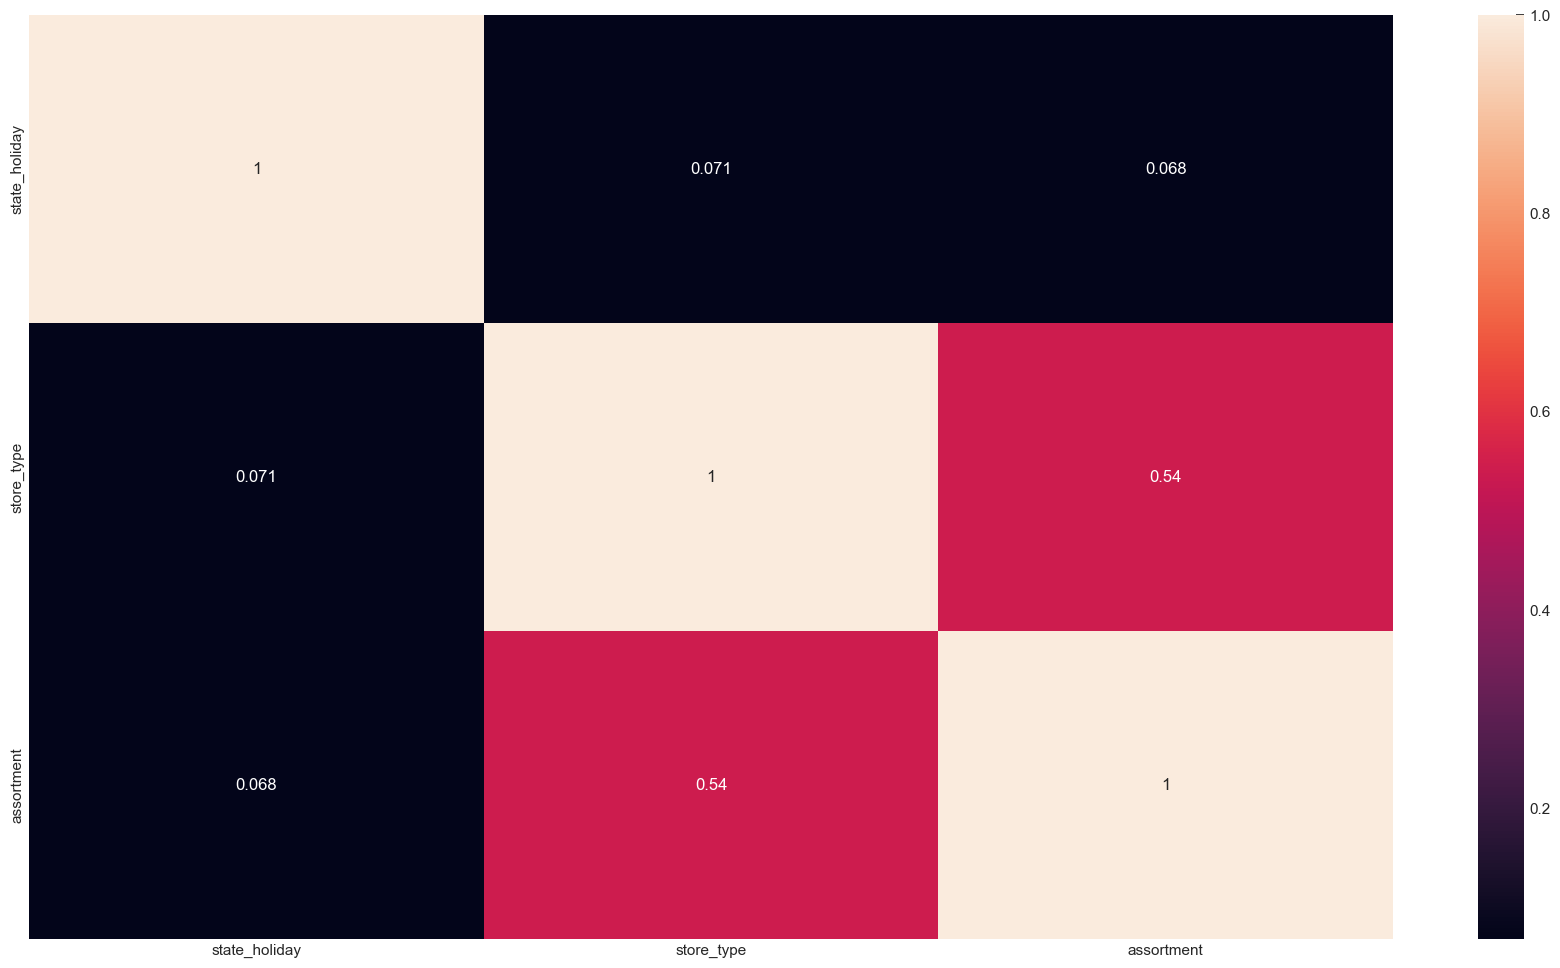

In [63]:
# only categorical data
cat = df4.select_dtypes( include ='object')

cat_list = ['state_holiday', 'store_type', 'assortment']
cramer_dic = {}

for c1 in cat_list:
    for c2 in cat_list:
        a = cramer_v(cat[c1], cat[c2])        
        
        if cat_list.index(c2) ==0:
            cramer_dic[c1] = []
            cramer_dic[c1].append(a)
        else:
            cramer_dic[c1].append(a)
            
cramer_v_table = pd.DataFrame (cramer_dic)            

cramer_v_table.set_index(cramer_v_table.columns,inplace=True)

sns.heatmap (cramer_v_table, annot = True);
    

# 5.0 Step 05 - DATA PREPARATION

In [64]:
df5 = df4.copy()

df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 5.1 Standardization

## 5.2 Normalization

In [43]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameters/competition_distance_scaler.pkl', 'wb'))

# competition time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameters/competition_time_month_scaler.pkl', 'wb'))

# promo2_since_week
df5['promo2_since_week'] = rs.fit_transform(df5[['promo2_since_week']].values)
pickle.dump(rs, open('parameters/promo2_since_week_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameters/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameters/year_scaler.pkl', 'wb'))

# competittion open since month
df5['competition_open_since_month'] = mms.fit_transform(df5[['competition_open_since_month']].values)
pickle.dump(mms, open('parameters/competition_open_since_month_scaler.pkl', 'wb'))

# competition open since year
df5['competition_open_since_year'] = mms.fit_transform(df5[['competition_open_since_year']].values)
pickle.dump(mms, open('parameters/competition_open_since_year_scaler.pkl', 'wb'))

# promo2_since_year
df5['promo2_since_year'] = mms.fit_transform(df5[['promo2_since_year']].values)
pickle.dump(mms, open('parameters/promo2_since_year_scaler.pkl', 'wb'))



## 5.3 Transformation

### 5.3.1 Encoding

In [44]:
# state holiday
df5 = pd.get_dummies (df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store type - label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type']).astype(np.int64)
pickle.dump(le, open('parameters/store_type_scaler.pkl','wb'))

# assortment
assortment_map = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_map)



### 5.3.2 Response Variable Transformation

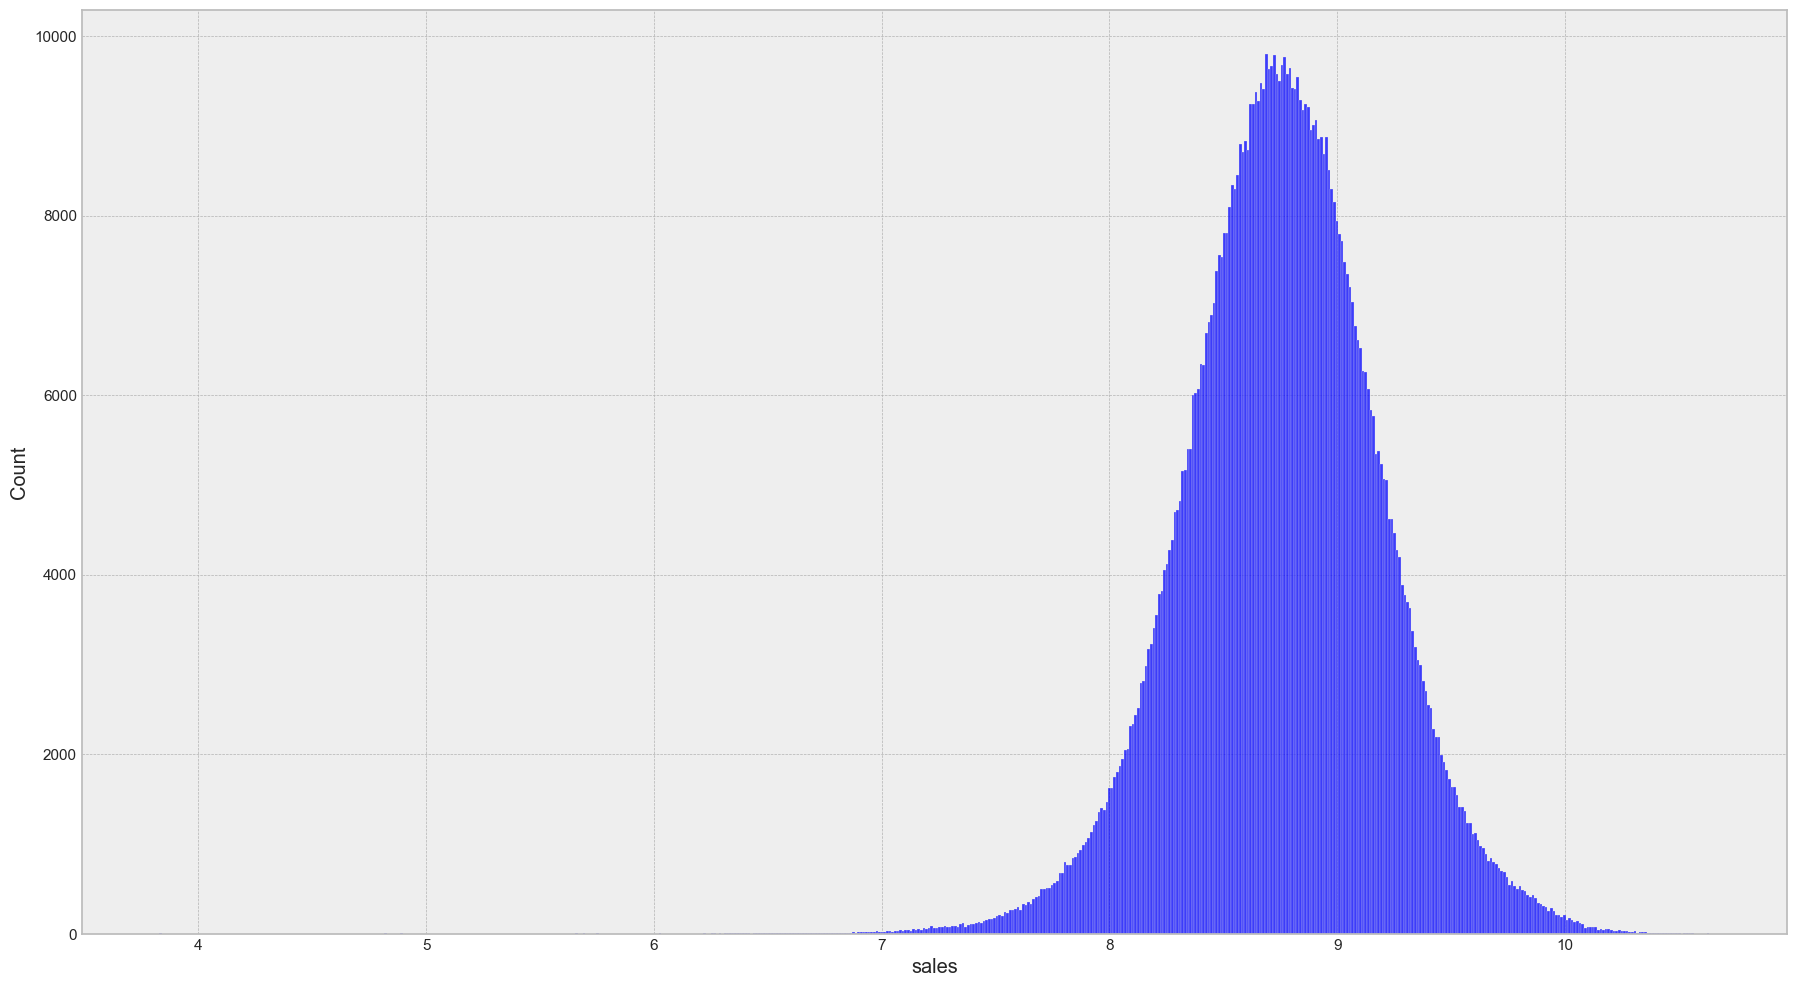

In [65]:
df5['sales'] = np.log(df5['sales'])
sns.histplot(df5['sales']);

### 5.3.3 Nature Transformation

In [46]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin (x*(2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos (x*(2.*np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin (x*(2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos (x*(2.*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin (x*(2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos (x*(2.*np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin (x*(2.*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos (x*(2.*np.pi/52)))


# 6.0 Step 06 - FEATURE SELECTION

In [47]:
df6 = df5.copy()

df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568456,1,1,2,1,-0.170968,0.727273,0.939130,0,0.000000,1.000000,0,1.0,7,31,31,2015-30,2008-09-01,0.809524,2015-07-27,0.299776,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710125,1,1,0,1,-0.283871,0.909091,0.930435,1,-2.000000,0.166667,1,1.0,7,31,31,2015-30,2007-11-01,0.928571,2010-03-22,0.923937,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025696,1,1,0,1,1.903226,1.000000,0.921739,1,-1.888889,0.333333,1,1.0,7,31,31,2015-30,2006-12-01,1.059524,2011-03-28,0.805369,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546455,1,1,2,3,-0.275806,0.727273,0.947826,0,0.000000,1.000000,0,1.0,7,31,31,2015-30,2009-09-01,0.654762,2015-07-27,0.299776,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.480944,1,1,0,1,4.448387,0.272727,1.000000,0,0.000000,1.000000,0,1.0,7,31,31,2015-30,2015-04-01,-0.142857,2015-07-27,0.299776,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## 6.1 Split dataframe into training and test dataset

In [48]:
cols_drop = ['competition_since','promo_since','day_of_week', 'day', 'month','week_of_year','year_week']
df6.drop(cols_drop, axis=1, inplace=True)

In [49]:
# the date 6 weeks before the last date in dataset
df6['date'].max() - datetime.timedelta(days=7*6)

Timestamp('2015-06-19 00:00:00')

In [50]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min date: {}'.format(X_train['date'].min()))
print('Training Max date: {}'.format(X_train['date'].max()))

print('Test Min date: {}'.format(X_test['date'].min()))
print('Test Max date: {}'.format(X_test['date'].max()))


Training Min date: 2013-01-01 00:00:00
Training Max date: 2015-06-18 00:00:00
Test Min date: 2015-06-19 00:00:00
Test Max date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [127]:
# training and test dataset for boruta
X_train_n = X_train.drop(['date','sales'],axis=1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=1)

# define boruta
boruta = BorutaPy(rf, n_estimators = 'auto', verbose =2, random_state=42).fit(X_train_n, y_train_n)


In [128]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop( ['date','sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))


cols_selected_boruta


In [51]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos']


## 6.3 Manual Feature Selector

In [52]:
# add week_of_year_sin and month_sin to cols_selected_boruta
cols_selected = ['store',
                 'promo',
                 'store_type',
                 'assortment',
                 'competition_distance',
                 'competition_open_since_month',
                 'competition_open_since_year',
                 'promo2_since_week',
                 'promo2_since_year',
                 'competition_time_month',
                 'promo_time_week',
                 'day_of_week_sin',
                 'day_of_week_cos',
                 'month_sin',
                 'month_cos',
                 'day_sin',
                 'day_cos',
                 'week_of_year_sin',
                 'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_full = cols_selected.copy()

cols_selected_full.extend(feat_to_add)


# 7.0 Step 07 - MACHINE LEARNING MODELING

In [53]:
x_train = X_train[cols_selected]
x_test = X_test[cols_selected]

# time series data preparation
x_training = X_train[cols_selected_full]

## 7.1 Average Model

In [155]:
aux1 = x_train.copy()
aux1['sales'] = y_train.copy()
aux2 = x_test.copy()

# predictions
aux3 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales':'predictions'})
aux2 = pd.merge(aux2, aux3, on='store', how='left')
yhat_baseline = aux2['predictions']

# performance
baseline_result = ml_error('Average Model',np.expm1(y_test), np.expm1(yhat_baseline))

baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1429.764812,0.216857,1939.336071


## 7.2 Linear Regression Model

In [158]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1873.819484,0.296787,2665.298064


### 7.2.1 Linear Regression Model - Cross Validation

In [187]:
lr_result_cv = cross_validation (x_training,5,'Linear Regression', lr, verbose=False )
lr_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2107.5 +/- 306.12,0.31 +/- 0.02,2974.64 +/- 495.88


## 7.3 Linear Regression Regularized Model - Lasso

In [159]:
# model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1902.778402,0.28866,2768.34


### 7.3.1 Lasso - Cross Validation

In [188]:
lrr_result_cv = cross_validation (x_training,5,'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2133.28 +/- 371.11,0.3 +/- 0.01,3070.37 +/- 555.28


## 7.4 Random Forest Regressor

In [160]:
# model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_tes), np.expm1(yhat_rf))
rf_result


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,672.726728,0.099776,994.551382


### 7.4.1 Random Forest Regressor - Cross Validation

In [189]:
rf_result_cv = cross_validation (x_training,5,'Random Forest Regressor', rf, verbose=True )
rf_result_cv

Kfold Number5

Kfold Number4

Kfold Number3

Kfold Number2

Kfold Number1



,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,848.66 +/- 296.68,0.12 +/- 0.03,1258.4 +/- 437.35


## 7.5 XGBoost Regressor

In [227]:
# model
model_xgb = xgb.XGBRegressor (objective = 'reg:squarederror',
                              n_estimators = 3000,
                              eta = 0.03,
                              max_depth = 5,
                              subsample = 0.7,
                              colsample_bytree =0.7 ).fit(x_train,y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb) )
xgb_result


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,760.411974,0.114123,1095.863166


### 7.5.1 XGBoost Regressor - Cross Validation

In [228]:
xgb_result_cv = cross_validation (x_training,5,'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv

Kfold Number5

Kfold Number4

Kfold Number3

Kfold Number2

Kfold Number1



,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,889.33 +/- 148.15,0.13 +/- 0.01,1278.44 +/- 209.9


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [229]:
modelling_result = pd.concat((baseline_result, lr_result, lrr_result, rf_result, xgb_result))
modelling_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1429.764812,0.216857,1939.336071
0,Linear Regression,1873.819484,0.296787,2665.298064
0,Linear Regression - Lasso,1902.778402,0.288660,2768.340000
0,Random Forest Regressor,672.726728,0.099776,994.551382
0,XGBoost Regressor,760.411974,0.114123,1095.863166


In [230]:
modelling_result.to_excel('models_performance/single_performance.xlsx')


### 7.6.2 Real Performance - Cross Validation

In [231]:
modelling_result_cv = pd.concat((lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv))
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2107.5 +/- 306.12,0.31 +/- 0.02,2974.64 +/- 495.88
0,Lasso,2133.28 +/- 371.11,0.3 +/- 0.01,3070.37 +/- 555.28
0,Random Forest Regressor,848.66 +/- 296.68,0.12 +/- 0.03,1258.4 +/- 437.35
0,XGBoost Regressor,889.33 +/- 148.15,0.13 +/- 0.01,1278.44 +/- 209.9


In [232]:
modelling_result_cv.to_excel('models_performance/cross_validation.xlsx')

# 8.0 Step 08 - HYPERPARAMETER FINE TUNING

In [233]:
param = {'n_estimators': [1500,2500,3000,3500],
         'eta': [0.01,0.03],
         'max_depth': [3,5,9],
         'subsample': [0.1,0.5,0.7],
         'colsample_bytree': [0.3,0.7,0.9],
         'min_child_weight': [3, 8, 15],
        }

MAX_EVAL = 5

## 8.1 Random Search

In [235]:
final_result = pd.DataFrame()

for i in range (MAX_EVAL):
    # choose values from parameters randomly
    hp = {k: random.sample(v,1)[0] for k,v in param.items()}
    print(hp)
    
    # model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimators = hp['n_estimators'],
                                 eta = hp['eta'],
                                 max_depth = hp['max_depth'],
                                 subsample = hp['subsample'],
                                 colsample_bytree = hp['colsample_bytree'],
                                 min_child_weight = hp['min_child_weight']).fit(x_train, y_train)
    
    # performance
    result = cross_validation(x_training,5,'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1199.88 +/- 167.85,0.17 +/- 0.01,1740.71 +/- 235.46
0,XGBoost Regressor,1015.28 +/- 140.32,0.14 +/- 0.01,1463.48 +/- 204.36
0,XGBoost Regressor,1345.8 +/- 160.19,0.18 +/- 0.01,1972.58 +/- 230.63
0,XGBoost Regressor,868.24 +/- 152.46,0.12 +/- 0.01,1244.39 +/- 214.92
0,XGBoost Regressor,1560.33 +/- 190.88,0.22 +/- 0.01,2251.2 +/- 264.96


In [236]:
hp = pd.DataFrame(hp, index=[0])

final_result_concat = pd.concat([hp,final_result], axis=1)

final_result_concat.to_excel('models_performance/hyperparameter_fine_tuning.xlsx')


## 8.2 Final Model

In [56]:
param_tuned = {'n_estimators': 3500 ,
               'eta': 0.03,
               'max_depth': 5,
               'subsample': 0.1,
               'colsample_bytree': 0.9,
               'min_child_weight': 3 }

In [57]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                   n_estimators = param_tuned['n_estimators'], 
                                   eta = param_tuned['eta'],
                                   max_depth = param_tuned['max_depth'],
                                   subsample = param_tuned['subsample'],
                                   colsample_bytree= param_tuned['colsample_bytree'],
                                   min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,733.907611,0.110574,1055.989794


In [58]:
pickle.dump(model_xgb_tuned,open('model/model_rossmann.pkl', 'wb'))

# 9.0 Step 09 - ERROR TRANSLATION AND INTERPRETATION

In [59]:
df9 = X_test[cols_selected_full]

# resolve
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [60]:
# sum of predictions
df91 = df9.groupby('store',as_index=False).sum()[['store','predictions']]

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on = 'store')

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92 [['store','predictions','worst_scenario','best_scenario','MAE','MAPE' ]]

In [61]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,167819.390625,167505.143370,168133.637880,314.247255,0.071856
1,2,182279.609375,181859.099939,182700.118811,420.509436,0.088023
2,3,265699.343750,265118.879632,266279.807868,580.464118,0.080940
3,4,344751.687500,343936.460845,345566.914155,815.226655,0.077819
4,5,174362.968750,173964.116782,174761.820718,398.851968,0.086562


## 9.2 Total Performance

In [65]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns = {'index':'Scenario',0:'Values'})

df93['Values'] = df93['Values'].map('€ {:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"€ 287,527,744.00"
1,worst_scenario,"€ 286,706,274.46"
2,best_scenario,"€ 288,349,243.73"


## 9.3 Machine Learning Performance

In [63]:
df9['error'] = df9['sales'] - df9['predictions']

df9['error_rate'] = (df9['predictions'] / df9['sales']-1)

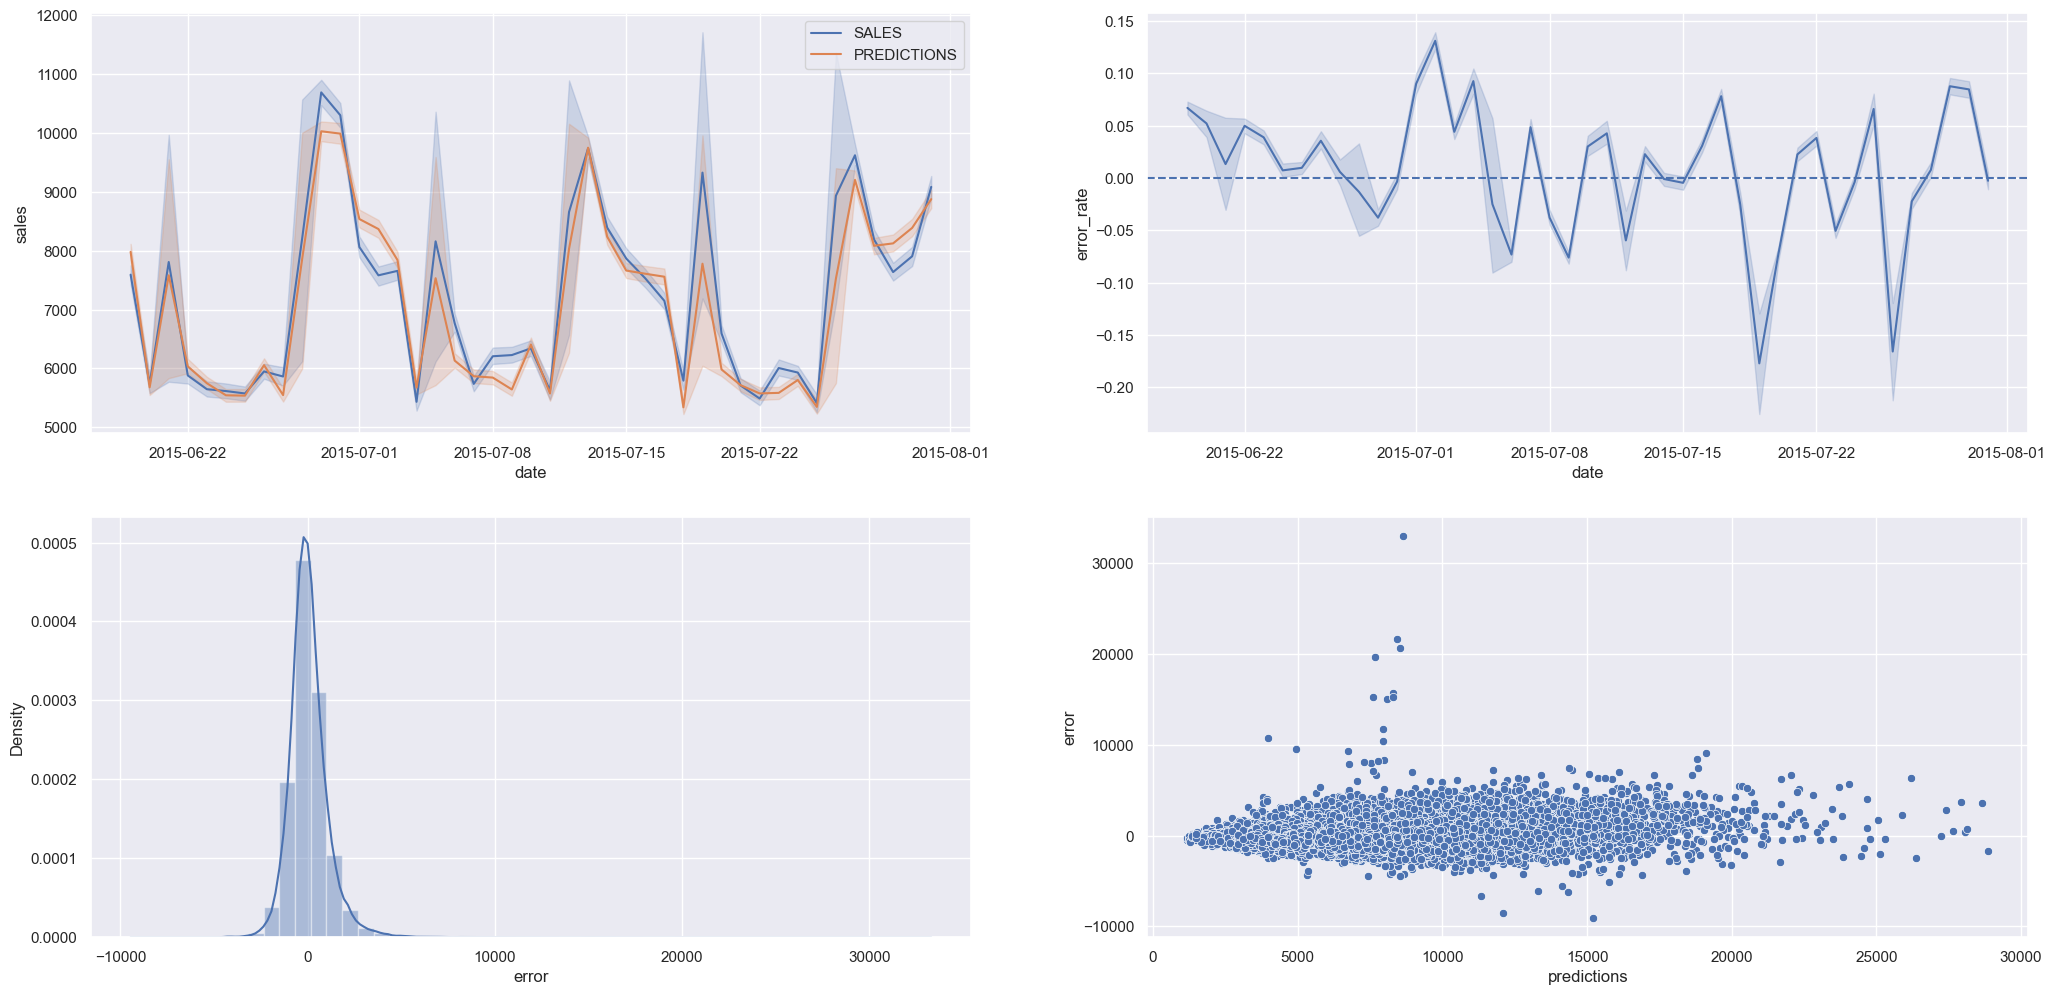

In [64]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data = df9, label = 'SALES');
sns.lineplot(x='date', y='predictions', data = df9, label = 'PREDICTIONS');

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data = df9);
plt.axhline(0,linestyle = '--')

plt.subplot(2,2,3)
sns.distplot(df9['error']);

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error']);

# 10.0 Step 10 - DEPLOY MODEL TO PRODUCTION

## 10.1 Rossmann Class

In [17]:
import pickle
import inflection
import numpy as np
import pandas as pd
import math
import datetime


class Rossmann (object):
    def __init__(self):
        state = 1
        self.home_path = 'C:/Users/SBG/repos/Curso_python/05_ds_producao/rossmann_sales_prediction/'
        self.competition_distance_scaler           = pickle.load( open (self.home_path + 'parameters/competition_distance_scaler.pkl','rb'))
        self.competition_open_since_month_scaler   = pickle.load( open (self.home_path + 'parameters/competition_open_since_month_scaler.pkl','rb'))
        self.competition_open_since_year_scaler    = pickle.load( open (self.home_path + 'parameters/competition_open_since_year_scaler.pkl','rb'))
        self.competition_time_month_scaler         = pickle.load( open (self.home_path + 'parameters/competition_time_month_scaler.pkl','rb'))      
        self.promo_time_week_scaler                = pickle.load( open (self.home_path + 'parameters/promo_time_week_scaler.pkl','rb'))
        self.promo2_since_week_scaler              = pickle.load( open (self.home_path + 'parameters/promo2_since_week_scaler.pkl','rb'))
        self.promo2_since_year_scaler              = pickle.load( open (self.home_path + 'parameters/promo2_since_year_scaler.pkl','rb'))
        self.year_scaler                           = pickle.load( open (self.home_path + 'parameters/year_scaler.pkl','rb'))
        self.store_type_scaler                     = pickle.load( open (self.home_path + 'parameters/store_type_scaler.pkl','rb'))  
            
        
    def data_cleaning (self,df1):
        
        ## 1.1. Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open','Promo','StateHoliday',
                    'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
                    'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                    'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # rename 
        df1.columns = cols_new

        ## 1.3 Data Types

        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Fillout NA

        # assumption that there is no competition so it will be considered a long distance  
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

        # assumption that there is no competition so it will be considered the last record of each store.
        ## last record of each store
        aux = df1.groupby('store', as_index = False).max()[['store','date']].rename(columns = {'date':'date_max'} )

        ## merge with dataset
        df1 = pd.merge(df1,aux, on='store', how='left')

        ## fillout NA
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date_max'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1 )
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date_max'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1 )

        df1['promo2_since_week'] = df1.apply( lambda x: x['date_max'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1 )
        df1['promo2_since_year'] = df1.apply( lambda x: x['date_max'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1 )


        # promo interval

        df1['promo_interval'].fillna(0, inplace=True)

        month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1.apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in str(x['promo_interval']).split(',') else 0, axis =1)


        ## 1.6 Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

        df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
        
        return df1
    

    def feature_engineering (self,df2):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month 

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis =1)

        df2['competition_time_month'] = df2.apply(lambda x: ((x['date'] - x['competition_since'])/30).days, axis = 1).astype(np.int64)

        # promo since
        df2['promo_since'] = df2.apply(lambda x: str(x['promo2_since_year']) + '-' + str(x['promo2_since_week']), axis =1)

        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime (x +'-1', '%Y-%W-%w')- datetime.timedelta(days=7) )

        df2['promo_time_week'] = df2.apply(lambda x: ((x['date'] - x['promo_since'])/7).days, axis = 1).astype(np.int64)

        # assortment 
        df2['assortment'] = df2['assortment'].apply (lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended') 

        # state holiday 
        df2['state_holiday'] = df2['state_holiday'].apply (lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day') 

        #  3.0 Step 03 - VARIABLE FILTERING

        ## 3.1 Rows Selection

        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]

        ## 3.2 Columns Selection

        cols_drop = ['open','month_map', 'date_max', 'promo_interval']

        df2.drop(cols_drop,axis=1, inplace= True)
        
        return df2
    
    def data_preparation (self,df5):
                       
        ## 5.2 Normalization

        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)

        # competition time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)

        # promo2_since_week
        df5['promo2_since_week'] = self.promo2_since_week_scaler.transform(df5[['promo2_since_week']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)

        # competittion open since month
        df5['competition_open_since_month'] = self.competition_open_since_month_scaler.transform(df5[['competition_open_since_month']].values)

        # competition open since year
        df5['competition_open_since_year'] = self.competition_open_since_year_scaler.transform(df5[['competition_open_since_year']].values)

        # promo2_since_year
        df5['promo2_since_year'] = self.promo2_since_year_scaler.transform(df5[['promo2_since_year']].values)

        ## 5.3 Transformation

        ### 5.3.1 Encoding

        # state holiday
        df5 = pd.get_dummies (df5, prefix = ['state_holiday'], columns = ['state_holiday'])

        # store type - label Encoding
        le = LabelEncoder()
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type']).astype(np.int64)

        # assortment
        assortment_map = {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_map)

     
        ### 5.3.3 Nature Transformation

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin (x*(2.*np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos (x*(2.*np.pi/7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin (x*(2.*np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos (x*(2.*np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin (x*(2.*np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos (x*(2.*np.pi/30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin (x*(2.*np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos (x*(2.*np.pi/52)))

        
        ## 6.3 Manual Feature Selector

        # add week_of_year_sin and month_sin to cols_selected_boruta
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 
                         'competition_open_since_year', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 
                         'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]

    def get_prediction (self,model,original_data,test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json (orient='records', date_format='iso')
        

## 10.2 API Handler

In [19]:
import pickle
import pandas as pd
from flask                 import Flask, request, Response
from rossmann.Rossmann     import Rossmann

# loading model
model = pickle.load (open ('C:/Users/SBG/repos/Curso_python/05_ds_producao/rossmann_sales_prediction/model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods = ['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance (test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # multiple examples
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys())
        
        # Instantiate Rossmann Class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')
    

if __name__ == '__main__':
    app.run('0.0.0.0')


ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [10]:
import requests
# loading test dataset
df10 = pd.read_csv('datasets/test.csv')

In [31]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([22,24,80]) ]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)


In [32]:
df_test.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
15,22,4,2015-09-17,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
17,24,4,2015-09-17,1.0,1,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
61,80,4,2015-09-17,1.0,1,0,0,d,a,7910.0,NaN,NaN,0,NaN,NaN,NaN
871,22,3,2015-09-16,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
873,24,3,2015-09-16,1.0,1,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"


In [33]:
# convert DataFrrame to json
data = json.dumps(df_test.to_dict(orient='records'))

In [34]:
# API call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-sales-model.herokuapp.com/rossmann/predict'
header = {'Content-type':'application/json'}
data = data

r = requests.post( url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))


Status Code 200


In [35]:
d1 = pd.DataFrame(r.json(),columns=r.json()[0].keys())

In [36]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store number {} will sell € {:,.2f} in the next 6 weeks'.format(
            d2.loc[i,'store'],
            d2.loc[i,'prediction']))  
    

Store number 22 will sell € 179,204.89 in the next 6 weeks
Store number 24 will sell € 382,323.75 in the next 6 weeks
Store number 80 will sell € 279,895.93 in the next 6 weeks
